# Fundus Image-Based Detection of Multiple Ocular Diseases Using Deep Convolutional Neural Networks

This notebook demonstrates the entire end-to-end process of developing our deep learning model.

Authored by: Derek Huynh, Matthew Biniam

### 0  Imports

Here multiple third-party and built-in libraries are imported for extended functionality within the scope of this
project. Models were built using the TensorFlow framework as well as its high-level API Keras. Various
data analysis and scientific computing libraries are also used including NumPy and Pandas. Seaborn and Matplotlib
are used for data visualization.

In [1]:
import os
import random
import sys
import datetime

import tensorflow as tf
import tqdm
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, f1_score

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})

# Color mappings for plots
viridis = plt.get_cmap('viridis')

# Min-max scale values to pass to cmap function
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

# Setting keras backend alias
K = keras.backend

In [ ]:
# For GPU's
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/dataset . 

### 1 Data Cleaning and Analysis

The data collected is sourced from 8 different public datasets containing a total of 18,236 retinal
fundus images. It is necessary to perform cursory data analysis on these in order to identify outliers and
determine a strategy to unify the features and labels to maximize the amount of usable data.

**Predicted issues that will have to be addressed:**
* Features and annotations are not likely to be shared along datasets, meaning it may be necesary to exclude those
  that may pose an issue when implementing them into the data pipeline of our model
* Different image sizes, formats, quality etc.

### 1.1 G1020 (Glaucoma)

G1020 is a very recently released glaucoma dataset, published on May 28th, 2020. It contains a total of 1020
retinal fundus images derived from 432 patients. 296 images are marked glaucoma positive and 724 are marked
healthy.

In [ ]:
# Paths to dataset
G1020_IMAGES = os.path.join(os.curdir, '../data/G1020/images/')
G1020_LABELS = os.path.join(os.curdir, '../data/G1020/G1020.csv')

# Using Pandas to read from the annotations
labels = pd.read_csv(G1020_LABELS)
print(labels.columns)
labels.tail(10)

Index(['Unnamed: 0', 'patientID', 'imageName', 'imageID', 'Left/Right',
       'detailedLabels', 'binaryLabels', 'diagnosis', 'gLabels'],
      dtype='object')


Unnamed: 0        patientID                                 imageName  \
1010        1010  zjzxx743ys8l297  ac8632d9-76e7-481c-a040-6db81013ce10.jpg   
1011        1011  zovo0er47tk3z7v  15c27078-6677-4b82-b56f-37f785ce464b.jpg   
1012        1012  zovo0er47tk3z7v  5314cd79-52fa-4360-a5ea-50754ff3776a.jpg   
1013        1013  zovo0er47tk3z7v  e0cf5297-461a-488b-ae40-b98df7f8e423.jpg   
1014        1014  zovo0er47tk3z7v  fa127b77-12cc-47d5-8d7b-30b6425969fb.jpg   
1015        1015  zv6f84bnud789vg  1b93736f-a295-4abc-acdf-5ae15d115bff.jpg   
1016        1016  zv6f84bnud789vg  f44193e6-2d1f-4824-b405-e32f8e4160df.jpg   
1017        1017  zzyw7okz2b8xvnl  549f9f45-fe3b-4838-8452-cbc957813652.jpg   
1018        1018  zzyw7okz2b8xvnl  d40d9881-d073-4539-85dc-e0109ae74a6e.jpg   
1019        1019  solihwy757bc165  0bd853d4-ced4-4667-9bf5-a4237bc904a8.jpg   

             imageID Left/Right detailedLabels  binaryLabels  \
1010  image_3170.jpg      Right             0a             0   
1011  image_3182.jpg      Right             1a             1   
1012  image_3183.jpg      Right             1a             1   
1013  image_3184.jpg       Left             1a             1   
1014  image_3185.jpg       Left             1a             1   
1015  image_3198.jpg       Left             0a             0   
1016  image_3199.jpg       Left             0a             0   
1017  image_3201.jpg       Left             1a             1   
1018  image_3202.jpg       Left             1a             1   
1019  image_2568.jpg      Right             0a             0   

                                              diagnosis gLabels  
1010  Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...     NaN  
1011  Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...     NaN  
1012  Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...     NaN  
1013  Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...     NaN  
1014  Hyperopie [H52.0 G], Astigmatismus [H52.2 G], ...     NaN  
1015  Hyperopie [H52.0 G], Astigmatismus [H52.2 G] |...     NaN  
1016  Hyperopie [H52.0 G], Astigmatismus [H52.2 G] |...     NaN  
1017  Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...     NaN  
1018  Myopie(G) [H52.1 G], Presbyopie(G) [H52.4 G], ...     NaN  
1019  Myopie [H52.1 GR], Presbyopie [H52.4 G], |BA, ...     NaN

Text(0.5, 1.0, 'G1020 Distribution')

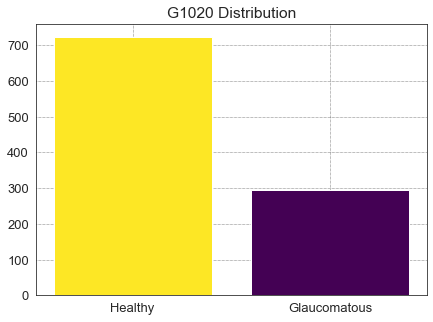

In [ ]:
# Distribution of G1020
x = ['Healthy', 'Glaucomatous']
y = labels['binaryLabels'].value_counts()

plt.bar(x, y, color=viridis(rescale(y)))
plt.title('G1020 Distribution')

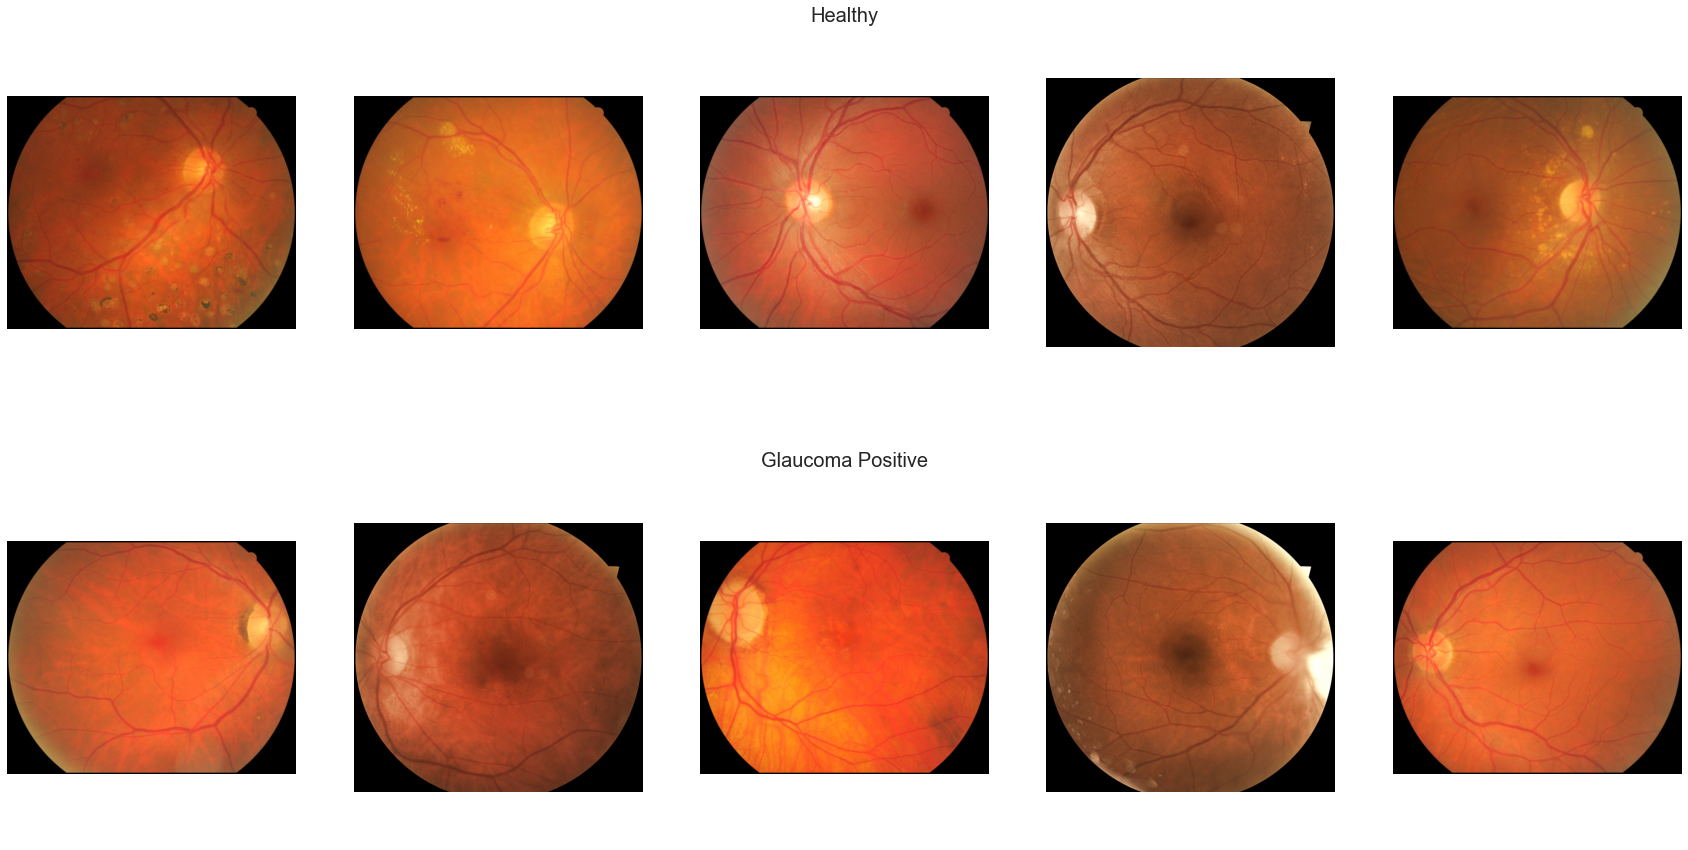

In [ ]:
# Get examples of healthy and glaucomous
healthy = labels['imageID'][labels['binaryLabels'] == 0][:5].tolist()
glaucoma = labels['imageID'][labels['binaryLabels'] == 1][:5].tolist()
examples = healthy + glaucoma

fig, axes = plt.subplots(2, 1, figsize=(30, 15), sharey=True)

for ind, row in enumerate(axes):
    if ind == 0:
        row.set_title('Healthy', fontsize=20)
    else:
        row.set_title('Glaucoma Positive', fontsize=20)
    # Removes axes and ticks
    row.axis('off')
    rwo.grid['off']
    # removes the white frame
    row._frameon = False
    
for i in range(1, 11):
    ax = fig.add_subplot(2, 5, i)
    ax.axis('off')
    img_path = os.path.join(G1020_IMAGES, examples[i-1])
    img = PIL.Image.open(img_path)
    ax.imshow(img)

### 1.2 IDRiD (Indian Diabetic Retinopathy Image Dataset)

In [ ]:
# Split into train and test images as well as labels
IDRID_IMAGES = os.path.join(os.curdir, '../data/idrid/train/')
IDRID_LABELS = os.path.join(os.curdir, '../data/idrid/train.csv')
IDRID_TEST = os.path.join(os.curdir, '../data/idrid/test.csv')

# Using Pandas to read from the annotations
labels = pd.read_csv(IDRID_LABELS)
print(labels.columns)
labels.tail(10)

Index(['Image name', 'Retinopathy grade', 'Risk of macular edema ',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')


Image name  Retinopathy grade  Risk of macular edema   Unnamed: 3  \
403  IDRiD_404                  2                       0         NaN   
404  IDRiD_405                  2                       1         NaN   
405  IDRiD_406                  0                       0         NaN   
406  IDRiD_407                  2                       1         NaN   
407  IDRiD_408                  1                       0         NaN   
408  IDRiD_409                  2                       1         NaN   
409  IDRiD_410                  2                       0         NaN   
410  IDRiD_411                  2                       0         NaN   
411  IDRiD_412                  2                       0         NaN   
412  IDRiD_413                  2                       0         NaN   

     Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
403         NaN         NaN         NaN         NaN         NaN         NaN   
404         NaN         NaN         NaN         NaN         NaN         NaN   
405         NaN         NaN         NaN         NaN         NaN         NaN   
406         NaN         NaN         NaN         NaN         NaN         NaN   
407         NaN         NaN         NaN         NaN         NaN         NaN   
408         NaN         NaN         NaN         NaN         NaN         NaN   
409         NaN         NaN         NaN         NaN         NaN         NaN   
410         NaN         NaN         NaN         NaN         NaN         NaN   
411         NaN         NaN         NaN         NaN         NaN         NaN   
412         NaN         NaN         NaN         NaN         NaN         NaN   

     Unnamed: 10 Unnamed: 11  
403          NaN         NaN  
404          NaN              
405          NaN         NaN  
406          NaN         NaN  
407          NaN         NaN  
408          NaN         NaN  
409          NaN         NaN  
410          NaN         NaN  
411          NaN         NaN  
412          NaN         NaN

The unnamed columns don't matter. From their 2018 paper, Diabetic Retinopathy (DR) grades range from 0(no DR) to 4
(severe DR) and Diabetic Macular Edema (DME) range from 0(no DME) to 2 (severe DME).

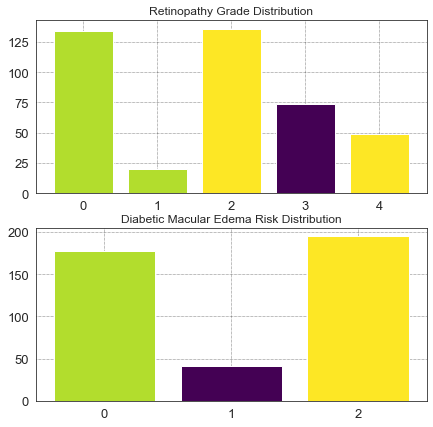

In [ ]:
# Getting counts of each rating
# Proportions seem to slightly favour unhealthy examples
mpl.rcParams['axes.grid'] = True
fig, axes = plt.subplots(2, 1, figsize=(7, 7))

dr = labels['Retinopathy grade']
dme = labels.iloc[:, 2]
dr_counts = labels['Retinopathy grade'].value_counts()
dme_counts = labels.iloc[:, 2].value_counts()

axes[0].set_title('Retinopathy Grade Distribution', fontsize=12)
axes[1].set_title('Diabetic Macular Edema Risk Distribution', fontsize=12)

axes[0].bar(dr_counts.index, dr_counts, color=viridis(rescale(dme_counts)))
axes[1].bar(dme_counts.index, dme_counts, color=viridis(rescale(dme_counts)))
ticks = axes[1].set_xticks(range(3))

A likely approach would be to rename the columns of each relevant disease to make it easier to
combine the datasets. In the case where there aren't grades of things like DR in other datasets, labels may have
to be modified to make them binary.

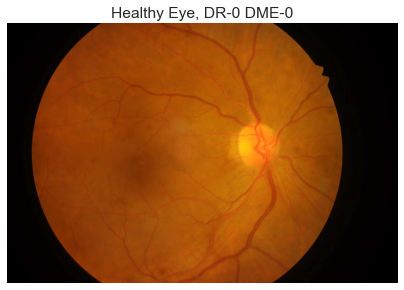

In [ ]:
healthy = labels['Image name'][(dr == 0) & (dme == 0)].tolist()[0]
dr_img = [labels['Image name'][(dr == i) & (dme == 0)].tolist()[0] for i in range(1, 5)]

# Something very interesting, there are no images with a DME rating that don't have
# a DR rating, that's why here we don't try to keep the DR grade at 0
dme_img = [labels['Image name'][dme == i].tolist()[0] for i in range(1, 3)]
examples = dr_img + dme_img

healthy_img = PIL.Image.open(IDRID_IMAGES + healthy + '.jpg')
plt.title('Healthy Eye, DR-0 DME-0')
plt.axis('off')
plt.imshow(healthy_img)

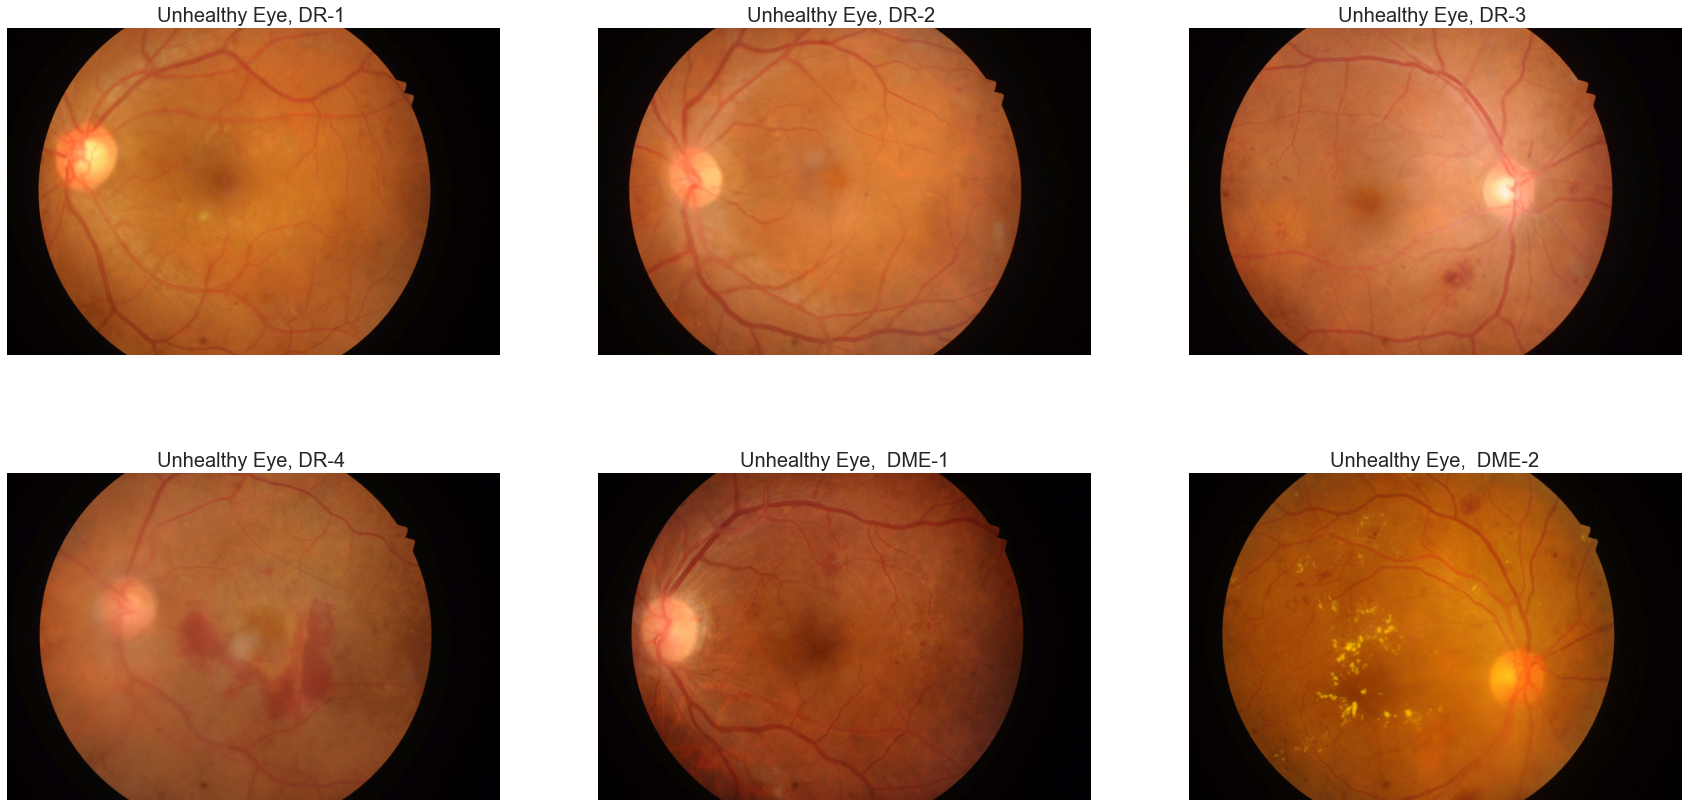

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharey=True)

ind = 0
dr_val = 0
dme_val = 0
for row in axes:
    for ax in row:
        ax.axis('off')
        ax.grid('off')
        if ind+1 > 4:
            dr_val = ''
            dme_val = f'DME-{ind+1 - 4}'
        else:
            dme_val = ''
            dr_val = f'DR-{ind+1}'
        ax.set_title(f'Unhealthy Eye, {dr_val} {dme_val}', fontsize=20)
        img_path = os.path.join(IDRID_IMAGES, examples[ind]+'.jpg')
        img = PIL.Image.open(img_path)
        ax.imshow(img)
        ind += 1

### 1.3 REFUGE (Glaucoma)

In [ ]:
REFUGE_IMAGES = os.path.join(os.curdir, '../data/refuge/train/')
REFUGE_LABELS = os.path.join(os.curdir, '../data/refuge/train.xlsx')
REFUGE_VALID = os.path.join(os.curdir, '../data/refuge/validation.xlsx')

# Need to add a column of glaucoma labels, they are given in the file name
# and are separated in the folders themselves
labels = pd.read_excel(REFUGE_LABELS)
labels

ID    ImgName  Fovea_X  Fovea_Y
0      1  g0001.jpg  1057.95  1076.52
1      2  g0002.jpg  1190.59  1017.09
2      3  g0003.jpg  1070.56  1084.85
3      4  g0004.jpg  1072.60  1035.48
4      5  g0005.jpg  1058.19  1100.33
..   ...        ...      ...      ...
395  396  n0356.jpg  1229.73  1043.89
396  397  n0357.jpg  1080.45  1081.30
397  398  n0358.jpg  1288.78  1122.37
398  399  n0359.jpg  1239.17  1077.17
399  400  n0360.jpg  1237.73  1089.06

[400 rows x 4 columns]

In [ ]:
corrected_names = 'REFUGE' + labels[40:].loc[:, 'ImgName']
labels.iloc[40:, 1] = corrected_names
labels

ID          ImgName  Fovea_X  Fovea_Y
0      1        g0001.jpg  1057.95  1076.52
1      2        g0002.jpg  1190.59  1017.09
2      3        g0003.jpg  1070.56  1084.85
3      4        g0004.jpg  1072.60  1035.48
4      5        g0005.jpg  1058.19  1100.33
..   ...              ...      ...      ...
395  396  REFUGEn0356.jpg  1229.73  1043.89
396  397  REFUGEn0357.jpg  1080.45  1081.30
397  398  REFUGEn0358.jpg  1288.78  1122.37
398  399  REFUGEn0359.jpg  1239.17  1077.17
399  400  REFUGEn0360.jpg  1237.73  1089.06

[400 rows x 4 columns]

In [ ]:
# Categorizing the images by their file names, those with glaucoma start with
# a 'g' and those without start with an 'n'
category = [0] * 400
image_names = labels['ImgName'].tolist()
for ind, val in enumerate(image_names):
    if val[0] is 'g':
        category[ind] = 1
    else:
        category[ind] = 0
labels['glaucoma'] = category
labels.head()
labels.to_csv('../data/refuge/train.csv', index=False)

In [ ]:
REFUGE_LABELS = os.path.join(os.curdir, '../data/refuge/train.csv')
labels = pd.read_csv(REFUGE_LABELS)
labels.tail(10)

ID          ImgName  Fovea_X  Fovea_Y  glaucoma
390  391  REFUGEn0351.jpg  1061.35  1017.61         0
391  392  REFUGEn0352.jpg  1170.87  1056.15         0
392  393  REFUGEn0353.jpg  1301.83  1037.36         0
393  394  REFUGEn0354.jpg  1149.57  1082.00         0
394  395  REFUGEn0355.jpg  1205.72  1078.18         0
395  396  REFUGEn0356.jpg  1229.73  1043.89         0
396  397  REFUGEn0357.jpg  1080.45  1081.30         0
397  398  REFUGEn0358.jpg  1288.78  1122.37         0
398  399  REFUGEn0359.jpg  1239.17  1077.17         0
399  400  REFUGEn0360.jpg  1237.73  1089.06         0

Text(0.5, 1.0, 'REFUGE Distribution')

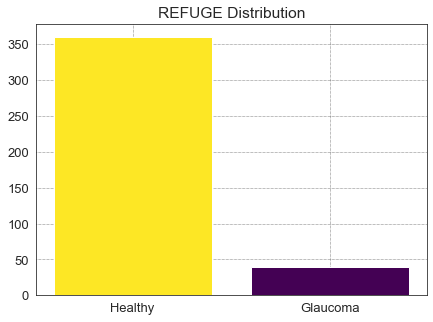

In [ ]:
x = ['Healthy', 'Glaucoma'] 
y = labels['glaucoma'].value_counts()
plt.bar(x, y, color=viridis(rescale(y)))
plt.title('REFUGE Distribution')

### 1.4 ADAM (Age-related Macular Degeneration)

In [2]:
# No labels are provided for this dataset
# but they are divided into their respected subdirectories
ADAM_IMAGES = os.path.join(os.curdir, '../data/amd/train/')
ADAM_LABELS = os.path.join(os.curdir, '../data/amd/adam_train.csv')

frame = {'image_names': [], 'AMD': []}
for file in os.listdir(ADAM_IMAGES):
    frame['image_names'].append(file)
    if file[0] == 'A':
        frame['AMD'].append(1)
    else:
        frame['AMD'].append(0)
labels = pd.DataFrame(frame)
labels.to_csv(ADAM_LABELS, index=False)
labels.tail()

image_names  AMD
396   N0223.jpg    0
397   N0237.jpg    0
398   N0021.jpg    0
399   N0035.jpg    0
400   N0009.jpg    0

Text(0.5, 1.0, 'ADAM AMD Distribution')

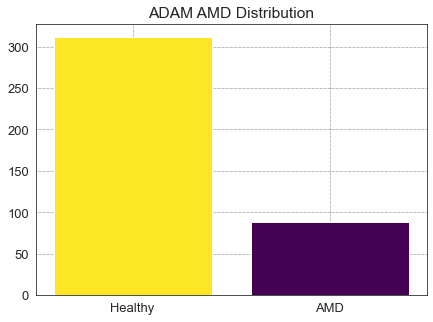

In [4]:
x = ['Healthy', 'AMD']
y = labels['AMD'].value_counts()

plt.bar(x, y, color=viridis(rescale(y)))
plt.title('ADAM AMD Distribution')

### 1.5 Messidor-2

Labels provided by Google Brain.

In [ ]:
# Contains both png and jpg files
MESSIDOR_IMAGES = os.path.join(os.curdir, '../data/messidor/train/')
MESSIDOR_LABELS = os.path.join(os.curdir, '../data/messidor/messidor_data.csv')
labels = pd.read_csv(MESSIDOR_LABELS)

# Need to correct the names of .jpg files
messidor_im = labels.iloc[labels.shape[0]-690:]['image_id'].tolist()
for i, name in enumerate(messidor_im):
    name = name.replace('jpg', 'JPG')
    messidor_im[i] = name
labels.iloc[labels.shape[0]-690:, 0] = messidor_im
MESSIDOR_LABELS = os.path.join(os.curdir, '../data/messidor/messidor_data_corrected.csv')
labels.to_csv(MESSIDOR_LABELS)
labels.tail(10)

image_id  adjudicated_dr_grade  adjudicated_dme  \
1738  IM004782.JPG                   0.0              0.0   
1739  IM004783.JPG                   0.0              0.0   
1740  IM004797.JPG                   1.0              0.0   
1741  IM004798.JPG                   0.0              0.0   
1742  IM004805.JPG                   0.0              0.0   
1743  IM004806.JPG                   0.0              0.0   
1744  IM004811.JPG                   1.0              0.0   
1745  IM004812.JPG                   2.0              0.0   
1746  IM004831.JPG                   0.0              0.0   
1747  IM004832.JPG                   0.0              0.0   

      adjudicated_gradable  
1738                     1  
1739                     1  
1740                     1  
1741                     1  
1742                     1  
1743                     1  
1744                     1  
1745                     1  
1746                     1  
1747                     1

<BarContainer object of 2 artists>

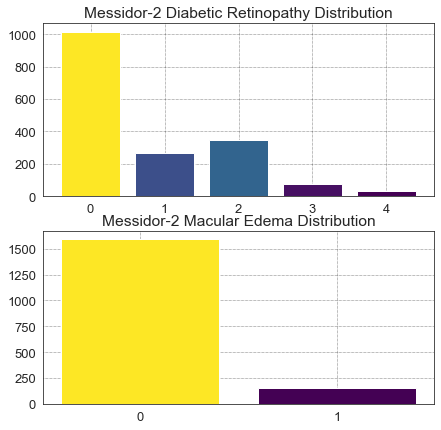

In [ ]:
# Diabetic retinopathy grades from 0 to 4
dr = labels.iloc[:, 1]
dr_count = dr.value_counts()

# Macular edema 
me = labels.iloc[:, 2]
me_count = me.value_counts()

fig, axes = plt.subplots(2, 1, figsize=(7,7))

# DR distributions
axes[0].set_xticks(range(5))
axes[0].set_title('Messidor-2 Diabetic Retinopathy Distribution')
axes[0].bar(dr_count.index, dr_count, color=viridis(rescale(dr_count)))

# ME distributions
axes[1].set_xticks(range(2))
axes[1].set_title('Messidor-2 Macular Edema Distribution')
axes[1].set_yticks(range(0, 1501, 250))
axes[1].bar(me_count.index, me_count, color=viridis(rescale(me_count)))

### 1.6 PALM (Myopia)

In [ ]:
# No labels provided for data set, category can be determined
# by the image names. P (pathological myopia), H (high myopia)
# and N (normal fundus)
PALM_IMAGES = os.path.join(os.curdir, '../data/palm/images/')
PALM_LABELS = os.path.join(os.curdir, '../data/palm/palm_train.csv')

# Creating labels based on file name
palm_labels = {'image_names': [], 'myopia': []}
for file in os.listdir(PALM_IMAGES):
    palm_labels['image_names'].append(file)
    category = file.strip('palm_')[0]
    if category is 'P' or category is 'H':
        palm_labels['myopia'].append(1)
    else:
        palm_labels['myopia'].append(0)
labels = pd.DataFrame(palm_labels)
labels.to_csv(PALM_LABELS, index=False)
labels.tail(10)

image_names  myopia
390  palm_P0095.jpg       1
391  palm_P0042.jpg       1
392  palm_P0056.jpg       1
393  palm_N0144.jpg       0
394  palm_N0150.jpg       0
395  palm_N0030.jpg       0
396  palm_N0024.jpg       0
397  palm_N0018.jpg       0
398  palm_P0136.jpg       1
399  palm_P0122.jpg       1

Text(0.5, 1.0, 'PALM Myopia Distribution')

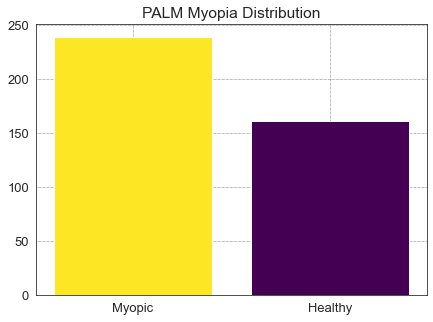

In [ ]:
x = ['Myopic', 'Healthy']
y = labels['myopia'].value_counts()
plt.bar(x, y, color=viridis(rescale(y)))
plt.title('PALM Myopia Distribution')

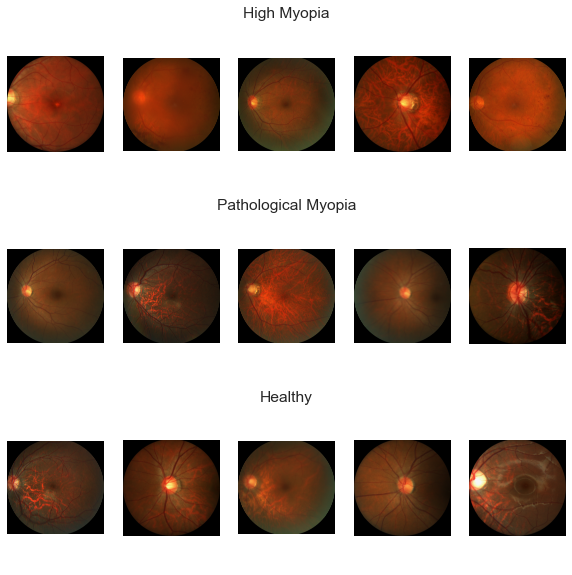

In [ ]:
# Getting image examples of high, pathological myopia and normal images
myopic = labels['image_names'][labels['myopia'] == 1].tolist()
healthy = labels['image_names'][labels['myopia'] == 0].iloc[:5].tolist()

high_myopia = []
pathological_myopia = []

for img_name in myopic:
    if img_name[5] is 'P':
        pathological_myopia.append(img_name)
    else:
        high_myopia.append(img_name)
        
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=True)
titles = ['High Myopia', 'Pathological Myopia', 'Healthy']
for ind, row in enumerate(axes):
    row.set_title(titles[ind])
    
    # Removes axes and ticks
    row.axis('off')
    row.grid('off')
    
    # removes the white frame
    row._frameon = False

# Add sub-subplots
for i in range(1, 16):
    ax = fig.add_subplot(3, 5, i)
    ax.axis('off')
    ax.grid('off')
    img_path = os.path.join(PALM_IMAGES, palm_images[i-1])
    img = PIL.Image.open(img_path)
    ax.imshow(img)

### 1.7 RFMiD (Multiple)

In [ ]:
RFMID_IMAGES = os.path.join(os.curdir, '../data/rfmid/train/')
RFMID_LABELS = os.path.join(os.curdir, '../data/rfmid/train.csv')
labels = pd.read_csv(RFMID_LABELS)

# Adding the .png file extension to the ID
file_names = labels['ID'].astype(str) + '.png'
labels['ID'] = file_names
labels.tail(10)

ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  \
1910  1911.png             0   0     0   0   0    0     0     0    0  ...   
1911  1912.png             0   0     0   0   0    0     0     0    0  ...   
1912  1913.png             0   0     0   0   0    0     0     0    0  ...   
1913  1914.png             1   0     0   0   0    0     0     1    0  ...   
1914  1915.png             1   0     0   0   0    0     0     1    0  ...   
1915  1916.png             1   0     0   0   0    0     0     0    0  ...   
1916  1917.png             1   1     0   0   0    0     0     0    0  ...   
1917  1918.png             0   0     0   0   0    0     0     0    0  ...   
1918  1919.png             0   0     0   0   0    0     0     0    0  ...   
1919  1920.png             0   0     0   0   0    0     0     0    0  ...   

      AION  PT  RT  RS  CRS  EDN  RPEC  MHL  RP  OTHER  
1910     0   0   0   0    0    0     0    0   0      0  
1911     0   0   0   0    0    0     0    0   0      0  
1912     0   0   0   0    0    0     0    0   0      0  
1913     0   0   0   0    0    0     0    0   0      0  
1914     0   0   0   0    0    0     0    0   0      0  
1915     0   0   0   0    0    0     0    0   0      0  
1916     0   0   0   0    0    0     0    0   0      0  
1917     0   0   0   0    0    0     0    0   0      0  
1918     0   0   0   0    0    0     0    0   0      0  
1919     0   0   0   0    0    0     0    0   0      0  

[10 rows x 30 columns]

In [ ]:
labels.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'OTHER'],
      dtype='object')

italicized text>"*This dataset consists of diseases/abnormalities (diabetic retinopathy (DR), age-related macular degeneration*
*(ARMD), media haze (MZ), drusen (DN), myopia (MYA), branch retinal vein occlusion (BRVO), tessellation (TSLN),*
*epiretinal membrane (ERM), laser scar (LS), macular scar (MS), central serous retinopathy (CSR), optic disc*
*cupping (ODC), central retinal vein occlusion (CRVO), tortuous vessels (TV), asteroid hyalosis (AH), optic disc*
*pallor (ODP), optic disc edema (ODE), shunt (ST), anterior ischemic optic neuropathy (AION), parafoveal*
*telangiectasia (PT), retinal traction (RT), retinitis (RS), chorioretinitis (CRS), exudation (EDN), retinal*
*pigment epithelium changes (RPEC), macular hole (MHL), retinitis pigmentosa (RP), cotton wool spots (CWS),*
*coloboma (CB), optic disc pit maculopathy (ODPM), preretinal hemorrhage (PRH), myelinated nerve fibers (MNF),*
*hemorrhagic retinopathy (HR), central retinal artery occlusion (CRAO), tilted disc (TD), cystoid macular edema* 
*(CME), post traumatic choroidal rupture (PTCR), choroidal folds (CF), vitreous hemorrhage (VH), macroaneurysm*
*(MCA), vasculitis (VS), branch retinal artery occlusion (BRAO), plaque (PLQ), hemorrhagic pigment epithelial*
*detachment (HPED) and collateral (CL))*" [Source](https://riadd.grand-challenge.org/Data/)

<BarContainer object of 28 artists>

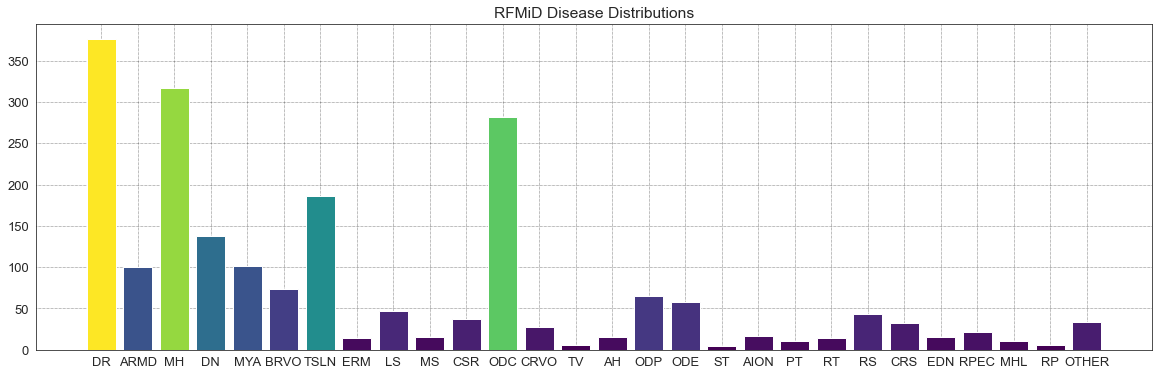

In [ ]:
# Plotting the distributions of the diseases in th data set
distributions = labels.iloc[:, 2:].sum()
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('RFMiD Disease Distributions')
ax.bar(distributions.index, distributions, color=dist_cmap(rescale(distributions)))

Text(0.5, 1.0, 'Healthy vs. Unhealthy RFMiD')

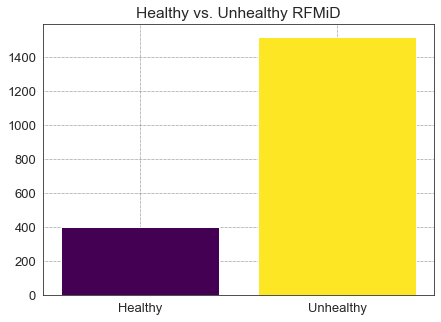

In [ ]:
# Healthy vs. Unhealthy labels
healthy = labels[labels['Disease_Risk'] == 0]['Disease_Risk'].shape[0]
unhealthy = labels['Disease_Risk'].sum()
x = ['Healthy', 'Unhealthy']
y = [healthy, unhealthy]
plt.bar(x, y, color=dist_cmap(rescale(y)))
plt.title('Healthy vs. Unhealthy RFMiD' )

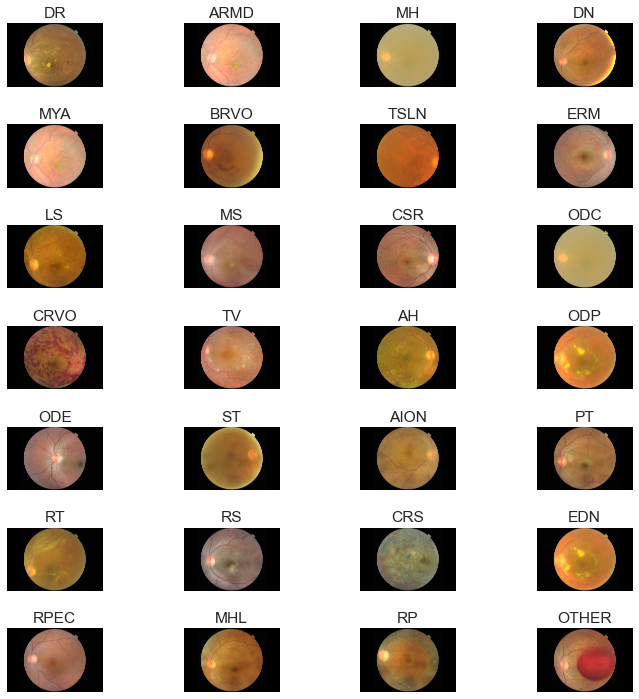

In [ ]:
# Examples of each disease
fig, axes = plt.subplots(7, 4, figsize=(10, 10))

# Keep a uniform layout and to prevent title spillover
fig.tight_layout()

diseases = labels.columns[2:]
rind = 0
cind = 0
for ind, col in enumerate(diseases):
    img_name = labels['ID'][labels[col] == 1].iloc[0]
    img = PIL.Image.open(RFMID_IMAGES + img_name)
    ax = axes[rind][cind]
    ax.grid('off')
    ax.axis('off')
    ax.set_title(col)
    ax.imshow(img)
    cind += 1
    if cind > len(axes[0]) - 1:
        cind = 0
        rind += 1

### 1.8 ODIR-5K (Multiple)

This dataset has diverse category labels and a large number of images.

In [ ]:
ODIR_IMAGES = os.path.join(os.curdir, '../data/odir/train/')
ODIR_LABELS = os.path.join(os.curdir, '../data/odir/train.xlsx')

labels = pd.read_excel(ODIR_LABELS)
labels.tail(10)

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
3490  4677           38        Male  4677_left.jpg  4677_right.jpg   
3491  4678           54        Male  4678_left.jpg  4678_right.jpg   
3492  4679           69        Male  4679_left.jpg  4679_right.jpg   
3493  4682           45        Male  4682_left.jpg  4682_right.jpg   
3494  4683           58        Male  4683_left.jpg  4683_right.jpg   
3495  4686           63        Male  4686_left.jpg  4686_right.jpg   
3496  4688           42        Male  4688_left.jpg  4688_right.jpg   
3497  4689           54        Male  4689_left.jpg  4689_right.jpg   
3498  4690           57        Male  4690_left.jpg  4690_right.jpg   
3499  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
3490                  mild nonproliferative retinopathy   
3491                  mild nonproliferative retinopathy   
3492             moderate non proliferative retinopathy   
3493                  mild nonproliferative retinopathy   
3494                                      normal fundus   
3495                severe nonproliferative retinopathy   
3496             moderate non proliferative retinopathy   
3497                  mild nonproliferative retinopathy   
3498                  mild nonproliferative retinopathy   
3499  hypertensive retinopathy，age-related macular d...   

                              Right-Diagnostic Keywords  N  D  G  C  A  H  M  \
3490                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3491                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3492             moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3493             moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3494                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3495                 proliferative diabetic retinopathy  0  1  0  0  0  0  0   
3496             moderate non proliferative retinopathy  0  1  0  0  0  0  0   
3497                                      normal fundus  0  1  0  0  0  0  0   
3498                  mild nonproliferative retinopathy  0  1  0  0  0  0  0   
3499  hypertensive retinopathy，age-related macular d...  0  0  0  0  1  1  0   

      O  
3490  0  
3491  0  
3492  0  
3493  0  
3494  0  
3495  0  
3496  0  
3497  0  
3498  0  
3499  0

In [ ]:
# The labels are per patient, however I can use the diagnostic keywords
# to create labels for each individual eye
left_keywords = labels.iloc[:, 5].unique()
right_keywords = labels.iloc[:, 6].unique()
keywords = np.concatenate([left_keywords, right_keywords])

def split_diagnoses(diagnosis):
    """
    Split up the diagnosis strings into a list. Annoyingly there are
    two different types of commas delineating the diagnostic labels
    
    Parameters
    ----------
    diagnosis: set
         Contains all the diagnostic labels in the dataset.
         
    Returns
    -------
    words: list
        The split diagnostic labels.
    """
    if '，' in diagnosis:
        words = diagnosis.split('，')
    else:
        words = diagnosis.split(',')
    return words 

def get_diagnoses(diagnoses):
    d = set()
    for diagnosis in diagnoses:
        # There are annoyingly two different commas separating the diagnoses
        words = split_diagnoses(diagnosis)
        for j in words:
            d.add(j)
    return d

diagnoses = get_diagnoses(keywords)
diagnoses, len(diagnoses)

({'abnormal pigment ',
  'age-related macular degeneration',
  'anterior segment image',
  'arteriosclerosis',
  'asteroid hyalosis',
  'atrophic change',
  'atrophy',
  'branch retinal artery occlusion',
  'branch retinal vein occlusion',
  'cataract',
  'central retinal artery occlusion',
  'central retinal vein occlusion',
  'central serous chorioretinopathy',
  'chorioretinal atrophy',
  'chorioretinal atrophy with pigmentation proliferation',
  'choroidal nevus',
  'congenital choroidal coloboma',
  'depigmentation of the retinal pigment epithelium',
  'diabetic retinopathy',
  'diffuse chorioretinal atrophy',
  'diffuse retinal atrophy',
  'drusen',
  'dry age-related macular degeneration',
  'epiretinal membrane',
  'epiretinal membrane over the macula',
  'fundus laser photocoagulation spots',
  'glaucoma',
  'glial remnants anterior to the optic disc',
  'hypertensive retinopathy',
  'idiopathic choroidal neovascularization',
  'image offset',
  'intraretinal hemorrhage',
  'i

In [ ]:
# Search for a given substring within diagnoses in the set
def get_kw(keyword, diagnoses_set):
    keyword_set = set()
    for kw in diagnoses_set:
        if keyword in kw:
            keyword_set.add(kw)
    return keyword_set

def create_kw(diagnoses_set):
    # Generate mappings for each disease
    normal_kw = set(['normal fundus'])
    non_indicator_kw = set(['lens dust', 'optic disk photographically invisible', 'anterior segment image', 'no fundus image', 'image offset', 'low image quality'])
    retinopathy_kw = get_kw('retinopathy', diagnoses_set)
    glaucoma_kw = get_kw('glaucoma', diagnoses_set)
    cataract_kw = get_kw('cataract', diagnoses_set)
    amd_kw = get_kw('age-related', diagnoses_set)
    hypertension_kw = get_kw('hypertens', diagnoses_set)
    myopia_kw = get_kw('myop', diagnoses_set)

    # Removing instances that belong to another class
    retinopathy_kw = retinopathy_kw.difference(myopia_kw)
    retinopathy_kw.remove('central serous chorioretinopathy')
    retinopathy_kw.remove('old chorioretinopathy')
    retinopathy_kw.remove('hypertensive retinopathy')

    # Determining the diagnoses present in the "other" category
    named_labels = normal_kw.union(retinopathy_kw, myopia_kw, glaucoma_kw, hypertension_kw, amd_kw, cataract_kw)
    other_kw = diagnoses.difference(named_labels.union(non_indicator_kw))
    
    kw = [normal_kw, retinopathy_kw, glaucoma_kw, cataract_kw, amd_kw, hypertension_kw, myopia_kw, other_kw]
    return kw

def match_diagnoses(diagnosis, df):
    """Some testing code to ensure that my algorithm will properly
    label the left and right fundus images using the diagnostic labels"""
    left = df.iloc[:, 5]
    left_index = left.index
    right = df.iloc[:, 6]
    right_index = right.index

    left_valid = set()
    right_valid = set()
    for ind, (left_d, right_d) in enumerate(zip(left.tolist(), right.tolist())):
        for d in diagnosis:
            if d in left_d:
                left_valid.add(left_index[ind])
            if d in right_d:
                 right_valid.add(right_index[ind])
                
    indices = list(left_valid.union(right_valid))
    return df.iloc[indices]

all_kw = create_kw(diagnoses)
cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for kw, label in zip(all_kw, cols):
    test = match_diagnoses(kw, labels)
    print(test[label].sum(), labels[label].sum())

1139 1140
1128 1128
215 215
212 212
164 164
103 103
174 174
979 979


> Note that the normal fundus images don't add up as there is one patient that does not have the keywords
'normal fundus' yet has been labeled as such (has 'low quality image' as a label, which will be removed 
anyways).

In [ ]:
def label_odir(keyword_sets, df):
    left = df.iloc[:, 5]
    left_index = left.index
    right = df.iloc[:, 6]
    right_index = right.index
    
    patient_id = []
    img_names = []
    labels = []
    diagnoses = []
    
    for dfind, (left_d, right_d) in enumerate(zip(left.tolist(), right.tolist())):
        l_one_hot = np.zeros(8, dtype=int)
        r_one_hot = np.zeros(8, dtype=int)
        ldiag = split_diagnoses(left_d)
        rdiag = split_diagnoses(right_d)
        for d in ldiag:
            for ind, kwset in enumerate(keyword_sets):
                if d in kwset:
                    l_one_hot[ind] = 1
                    break
        for d in rdiag:
            for ind, kwset in enumerate(keyword_sets):
                if d in kwset:
                    r_one_hot[ind] = 1
                    break
        row = df.iloc[dfind]
        patient_id.extend([row['ID']] * 2)
        img_names.extend([row['Left-Fundus'], row['Right-Fundus']])
        diagnoses.append(','.join(ldiag))
        diagnoses.append(','.join(rdiag))
        labels.append(l_one_hot)
        labels.append(r_one_hot)
        
    columns = ['ID', 'image_name', 'diagnosis', 'N', 'DR', 'G', 'C', 'AMD', 'H', 'M', 'O']
    patient_id = np.asarray(patient_id).reshape(-1, 1)
    img_names = np.asarray(img_names).reshape(-1, 1)
    diagnoses = np.asarray(diagnoses).reshape(-1, 1)
    labels = np.asarray(labels)
    dataset = np.concatenate([patient_id, img_names, diagnoses, labels], axis=1)
    dataset = pd.DataFrame(dataset, columns=columns)
    return dataset

# Drop rows where there are no labels, which means the fundus images lack
# any labels with actionable indicators of disease (labels in the non_indicator_kw set)
odir_labeled = label_odir(all_kw, labels)
no_indicators = odir_labeled[odir_labeled.iloc[:, 3:].sum(axis=1) == 0].index
odir_labeled = odir_labeled.drop(no_indicators)
ODIR_LABELS = './../data/odir/odir_train.csv'
odir_labeled.to_csv(ODIR_LABELS, index=False)

# 30 rows dropped in total
odir_labeled.tail()

ID      image_name                                          diagnosis  \
0        0      0_left.jpg                                           cataract   
1        0     0_right.jpg                                      normal fundus   
2        1      1_left.jpg                                      normal fundus   
3        1     1_right.jpg                                      normal fundus   
4        2      2_left.jpg  laser spot,moderate non proliferative retinopathy   
...    ...             ...                                                ...   
6995  4689  4689_right.jpg                                      normal fundus   
6996  4690   4690_left.jpg                  mild nonproliferative retinopathy   
6997  4690  4690_right.jpg                  mild nonproliferative retinopathy   
6998  4784   4784_left.jpg  hypertensive retinopathy,age-related macular d...   
6999  4784  4784_right.jpg  hypertensive retinopathy,age-related macular d...   

      N DR  G  C AMD  H  M  O  
0     0  0  0  1   0  0  0  0  
1     1  0  0  0   0  0  0  0  
2     1  0  0  0   0  0  0  0  
3     1  0  0  0   0  0  0  0  
4     0  1  0  0   0  0  0  1  
...  .. .. .. ..  .. .. .. ..  
6995  1  0  0  0   0  0  0  0  
6996  0  1  0  0   0  0  0  0  
6997  0  1  0  0   0  0  0  0  
6998  0  0  0  0   1  1  0  0  
6999  0  0  0  0   1  1  0  0  

[6970 rows x 11 columns]

### 2 Creating the Dataset

Now that each dataset has been cleaned and prepared, we can now consolidate them all into a single one for our
deep learning model.

In [ ]:
# Create one single .csv containing the categories, image names
# as well as the dataset where each image originated from.
g1020 = pd.read_csv(G1020_LABELS)
idrid = pd.read_csv(IDRID_LABELS)
idrid_test = pd.read_csv(IDRID_TEST)
refuge = pd.read_csv(REFUGE_LABELS)
refuge_valid = pd.read_excel(REFUGE_VALID)
adam = pd.read_csv(ADAM_LABELS)
messidor = pd.read_csv(MESSIDOR_LABELS)
palm = pd.read_csv(PALM_LABELS)
rfmid = pd.read_csv(RFMID_LABELS)
odir = pd.read_csv(ODIR_LABELS)

In [ ]:
# Converting IDRiD and Messidor-2 to binary labels
idrid_dr = idrid['Retinopathy grade']
idrid_dr = np.where(idrid_dr > 0, 1, 0).reshape(-1, 1)
idrid['Retinopathy grade'] = idrid_dr
idrid['Image name'] += '.jpg'

# IDRiD test
idrid_test_dr = idrid_test['Retinopathy grade']
idrid_test_dr = np.where(idrid_test_dr > 0, 1, 0).reshape(-1, 1)
idrid_test['Retinopathy grade'] = idrid_test_dr
idrid_test['Image name'] = 'T' + idrid_test['Image name'] + '.jpg'

# Messidor-2
messidor_dr = messidor['adjudicated_dr_grade']
messidor_dr = np.where(messidor_dr > 0, 1, 0).reshape(-1, 1)
messidor['adjudicated_dr_grade'] = messidor_dr

In [ ]:
# Formatting all the datasets and combining them into one
def format_binary(image_col, label_col, category, origin, dset_cols, df):
    # Getting image and label columns
    image_names = df[image_col] 
    image_names = image_names.rename('image_name')
    labels = df[label_col]
    dset_cat = {'DR': 1, 'G': 2, 'C': 3, 'AMD': 4, 'H': 5, 'M': 6, 'O': 7}

    # Creating array of one hot vectors for disease positive
    disease_pos = labels[labels == 1]
    disease_ind = disease_pos.index
    disease_labels = disease_pos.to_numpy()
    pos_one_hots = np.zeros((disease_labels.shape[0], 8), dtype=object)
    pos_one_hots[:, dset_cat[category]] = disease_pos

    # Creating array of one hot vectors for healthy
    healthy = labels[labels == 0]
    healthy_ind = healthy.index
    healthy_labels = np.ones(healthy.to_numpy().shape, dtype=int)
    neg_one_hots = np.zeros((healthy_labels.shape[0], 8), dtype=object)
    neg_one_hots[:, 0] = healthy_labels

    # Concatenating the images with the labels
    disease_pos = np.concatenate([image_names[disease_ind].to_numpy().reshape(-1, 1),
                    np.array([origin] * pos_one_hots.shape[0]).reshape(-1, 1),
                    pos_one_hots], axis=1)

    healthy = np.concatenate([image_names[healthy_ind].to_numpy().reshape(-1, 1),
                    np.array([origin] * neg_one_hots.shape[0]).reshape(-1, 1),
                    neg_one_hots], axis=1)

    df_formatted = pd.DataFrame(np.concatenate([disease_pos, healthy], axis=0), columns=dset_cols)
    return df_formatted

# We will use the same categories as ODIR for the dataset and also add an origin 
# column to better identify which datasets each image belongs to
dset = odir.drop(['ID', 'diagnosis'], axis=1)
dset.insert(1, 'origin', ['ODIR'] * odir.shape[0])

# Concatenating all the datasets with binary labels, only one that isn't is RFMiD
dset = dset.append(format_binary('imageID', 'binaryLabels', 'G', 'G1020', dset.columns, g1020))
dset = dset.append(format_binary('Image name', 'Retinopathy grade', 'DR', 'IDRiD', dset.columns, idrid))
dset = dset.append(format_binary('Image name', 'Retinopathy grade', 'DR', 'IDRiD', dset.columns, idrid_test))
dset = dset.append(format_binary('ImgName', 'glaucoma', 'G', 'REFUGE', dset.columns, refuge))
dset = dset.append(format_binary('ImgName', 'Glaucoma Label', 'G', 'REFUGE', dset.columns, refuge_valid))
dset = dset.append(format_binary('image_names', 'AMD', 'AMD', 'ADAM', dset.columns, adam))
dset = dset.append(format_binary('image_id', 'adjudicated_dr_grade', 'DR', 'MESSIDOR-2', dset.columns, messidor))
dset = dset.append(format_binary('image_names', 'myopia', 'M', 'PALM', dset.columns, palm))

# Formatting and appending RFMiD
rfmid_images = rfmid['ID'].astype('U') + '.png'
rfmid_images.rename('image_name')

# Diseased instances
rfmid_disease = rfmid[rfmid['Disease_Risk'] == 1]
rfmid_disease_ind = rfmid_disease.index
pos_one_hots = np.zeros((rfmid_disease.shape[0], 8), dtype=int)

# DR
rfmid_dr = rfmid_disease['DR'].astype(int)
pos_one_hots[:, 1] = rfmid_dr

# AMD
rfmid_amd = rfmid_disease['ARMD'].astype(int)
pos_one_hots[:, 4] = rfmid_amd

# Myopia
rfmid_myopia = rfmid_disease['MYA'].astype(int)
pos_one_hots[:, 6] = rfmid_myopia

# Other diseases
rfmid_other = (rfmid_disease.drop(['DR', 'ARMD', 'MYA'], axis=1).iloc[:, 2:].sum(axis=1) > 0).astype(int)
pos_one_hots[:, 7] = rfmid_other

# Healthy
rfmid_healthy = rfmid[rfmid['Disease_Risk'] == 0]
rfmid_healthy_ind = rfmid_healthy.index
neg_one_hots = np.zeros((rfmid_healthy.shape[0], 8), dtype=int)
neg_one_hots[:, 0] = np.ones(rfmid_healthy.shape[0], dtype=int)

# Concatenating the images with the labels
rfmid_disease = np.concatenate([rfmid_images[rfmid_disease_ind].to_numpy().reshape(-1, 1),
                np.array(['RFMiD'] * pos_one_hots.shape[0]).reshape(-1, 1),
                pos_one_hots], axis=1)

rfmid_healthy = np.concatenate([rfmid_images[rfmid_healthy_ind].to_numpy().reshape(-1, 1),
                np.array(['RFMiD'] * neg_one_hots.shape[0]).reshape(-1, 1),
                neg_one_hots], axis=1)

rfmid_formatted = pd.DataFrame(np.concatenate([rfmid_disease, rfmid_healthy], axis=0), columns=dset.columns)
dset = dset.append(rfmid_formatted)

# Resetting index
dset.index = range(dset.shape[0])
dset.tail()

image_name origin  N DR  G  C AMD  H  M  O
13770   1912.png  RFMiD  1  0  0  0   0  0  0  0
13771   1913.png  RFMiD  1  0  0  0   0  0  0  0
13772   1918.png  RFMiD  1  0  0  0   0  0  0  0
13773   1919.png  RFMiD  1  0  0  0   0  0  0  0
13774   1920.png  RFMiD  1  0  0  0   0  0  0  0

In [ ]:
# Saving labels to dataset folder where all images are in the same directory
dset.to_csv(os.path.join(os.curdir, '../dataset/dataset.csv'), index=False)

In [ ]:
# Checking if all images are present
DATASET_IMAGES = os.path.join(os.curdir, '../dataset/images/')
dataset_dirnames = set(os.listdir(DATASET_IMAGES))
dataset_image_names = set(dset['image_name'].tolist())
dataset_image_names.difference(dataset_dirnames)

set()

All images in our DataFrame are present in our dataset directory. We can get started on preprocessing the data and 
training the model. After cleaning our images now total 13,775.

### 3 Data Preprocessing and Pipelining

In [ ]:
# For Colab
DSET_IMAGES = os.path.join(os.curdir, './dataset/images/')
DSET_LABELS = os.path.join(os.curdir, '/content/drive/MyDrive/dataset/dataset.csv')

# On prem
# DSET_IMAGES = os.path.join(os.curdir, '../dataset/images/')
# DSET_LABELS = os.path.join(os.curdir, '../dataset/dataset.csv')

dset = pd.read_csv(DSET_LABELS).iloc[:, 1:]

In [ ]:
dset = dset.sample(frac=1, random_state=42).reset_index(drop=True)
dset.tail()

image_name origin  N  DR  G  C  AMD  H  M  O
13770  3222_right.jpg   ODIR  1   0  0  0    0  0  0  0
13771         313.png  RFMiD  1   0  0  0    0  0  0  0
13772  3322_right.jpg   ODIR  1   0  0  0    0  0  0  0
13773   431_right.jpg   ODIR  0   1  0  0    0  0  0  0
13774     image_5.jpg  G1020  1   0  0  0    0  0  0  0

In [ ]:
X = (DSET_IMAGES + dset['image_name'])
y = dset.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=int(dset.shape[0]*0.1))

y_train = tf.constant(y_train)
y_val = tf.constant(y_val)
y_test = tf.constant(y_test)

In [ ]:
# Defining helper functions to convert to serializeable data types for TFRecord
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Create an example class for the TFRecord protobuf
def create_example(image_string, labels):
    feature = {
        'image_raw': _bytes_feature(image_string.numpy()),
        'labels': _bytes_feature(tf.io.serialize_tensor(labels).numpy()),
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto

def crop_image(img, tol=4):
    # tol is tolerance, pixels to exclude from the mask
    img = np.asarray(img)
    mask = img > tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    img = img[row_start:row_end,col_start:col_end]
    img = tf.convert_to_tensor(img)
    return img

def create_record(path, X, y):
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    y = tf.convert_to_tensor(y)
    with tf.io.TFRecordWriter(path, options=options) as writer:
        for i in range(len(X)):
            try:
                image = tf.io.decode_image(tf.io.read_file(X[i]))
            except tf.errors.InvalidArgumentError as e:
                print(X[i])
                continue
            image = tf.io.decode_image(tf.io.read_file(X[i]))
            image = crop_image(image)
            image = tf.image.resize(image, (244, 244), method='nearest', preserve_aspect_ratio=True)
            image = tf.io.encode_jpeg(image)
            label = y[i]
            tf_example = create_example(image, label)
            writer.write(tf_example.SerializeToString())

# On prem
#dset_train = os.path.join(os.curdir, '../records244/train')
#dset_val = os.path.join(os.curdir, '../records244/dset_val.tfrecord')
#dset_test = os.path.join(os.curdir, '../records244/dset_test.tfrecord')

# Colab
dset_train = os.path.join(os.curdir, './records244/dset_train.tfrecord')
dset_val = os.path.join(os.curdir, './records244/dset_val.tfrecord')
dset_test = os.path.join(os.curdir, './records244/dset_test.tfrecord')

#create_record(dset_train, X_train, y_train)
#create_record(dset_val, X_val, y_val)
#create_record(dset_test, X_test, y_test)

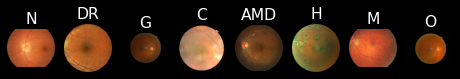

In [ ]:
# Visualizing examples from our dataset
fig, axes = plt.subplots(1, 8, figsize=(8, 15))
plt.style.use('dark_background')
axes = axes.ravel()

for i in range(8):
    fundus = y_train[:, i] == 1
    ind = np.argmax(fundus)
    img = tf.image.resize(crop_image(tf.io.decode_image(tf.io.read_file(X_train[ind]))), (244, 244), preserve_aspect_ratio=True) / 255
    ax = axes[i]
    ax.set_title(dset.columns[2:][i])
    ax.grid('off')
    ax.axis('off')
    ax.imshow(img)

In [ ]:
# Copying records to Colab VM from Drive
drive_records = '/content/drive/MyDrive/records'
!cp -r $drive_records .

In [ ]:
!tar -xvf ./records/retina_records_244.tar.gz -C ./
!tar -xvf ./records/records_over1000.tar.gz -C ./

records244/
records244/dset_train.tfrecord
records244/dset_val.tfrecord
records244/dset_test.tfrecord
records_over1000/
records_over1000/dset_train.tfrecord


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.random.set_seed(42)
random.seed(42)
train_dataset = tf.data.TFRecordDataset(dset_train, compression_type='GZIP').shuffle(2048)
val_dataset = tf.data.TFRecordDataset(dset_val, compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset(dset_test, compression_type='GZIP')

def _parse_dataset(example_proto, img_size=[244, 244]):
    image_feature_description = {
        'labels': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    labels = tf.io.parse_tensor(parsed['labels'], tf.int64)
    labels.set_shape((8,))
    image = tf.io.decode_image(parsed['image_raw']) / 255
    image.set_shape(img_size + [3])
    return image, labels

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'labels': tf.io.FixedLenFeature([], tf.string)
}
train_dataset = train_dataset.map(_parse_dataset, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
val_dataset = val_dataset.map(_parse_dataset, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(_parse_dataset, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

<dtype: 'float32'>


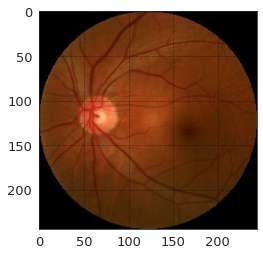

In [ ]:
for i in train_dataset.take(1):
    plt.imshow(i[0][0])
    print(i[0][0].dtype)

In [ ]:
# Split a single TF Record into multiple files
def _parse_raw_dataset(example_proto, img_size=[360, 360]):
    parsed = tf.io.parse_single_example(example_proto, image_feature_description)
    labels = tf.io.parse_tensor(parsed['labels'], tf.int64)
    labels.set_shape((8,))
    image = parsed['image_raw']
    return image, labels

def shard_tfrecord(path, name, record):
    options = tf.io.TFRecordOptions(compression_type='GZIP')
    dset = tf.data.TFRecordDataset(record, compression_type='GZIP')
    dset = dset.map(_parse_raw_dataset).batch(1000)
    batch_id = 0
    for batch in dset:
        batch_ds = tf.data.Dataset.from_tensor_slices(batch)
        filename = f'{name}.{batch_id:03d}'
        record_path = os.path.join(path, filename)
        with tf.io.TFRecordWriter(record_path, options=options) as writer:
            for ex in batch_ds:
                tf_example = create_example(*ex)
                writer.write(tf_example.SerializeToString())
        batch_id += 1
        
def augment_image(image):
    image = tf.image.random_flip_left_right(image, seed=42)
    image = tf.image.random_flip_up_down(image, seed=42)
    image = tf.image.random_contrast(image, 0.8, 1.0, seed=42)
    image = tf.image.random_brightness(image, 0.1, seed=42)
    image = tf.minimum(image, 255)
    return image

def oversample_dataset(record, target):
    labels = []
    images = []
    
    augmented_images = []
    augmented_labels = []
    
    for batch in record:
        image = batch[0]
        label = batch[1]
        images.append(image)
        labels.append(label)
        
    images = tf.concat(images, 0)
    labels = tf.concat(labels, 0)
   
    for i in range(8):
        current = labels[:, i] == 1
        current_img = images[current]
        current_labels = labels[current]
        current_number = current_img.shape[0]
        
        # Number of images we need to create
        num_create = target - current_number
        
        if num_create < 0:
            augmented_images.extend(current_img)
            augmented_labels.extend(current_labels)
            continue
        
        ind = 0 
        for j in tqdm.trange(num_create):
            over_img = tf.io.decode_image(current_img[ind])
            over_lab = current_labels[ind]
            over_img = tf.io.encode_jpeg(augment_image(over_img))
            
            augmented_images.append(over_img)
            augmented_labels.append(over_lab)
            ind = min(ind, current_img.shape[0]-1)
            
        augmented_images.extend(current_img)
        augmented_labels.extend(current_labels)
            
    augmented_images = tf.stack(augmented_images)
    augmented_labels = tf.stack(augmented_labels)
    
    tf.random.set_seed(42)
    indices = tf.random.shuffle(tf.range(augmented_images.shape[0]), seed=42)
    augmented_images = tf.gather(augmented_images, indices)
    augmented_labels = tf.gather(augmented_labels, indices)
    
    return augmented_images, augmented_labels
        
def undersample(majority_images, majority_labels, target):
    tf.random.set_seed(42)
    indices = tf.random.shuffle(tf.range(majority_images.shape[0]), seed=42)[:target]
    under_sampled_img = tf.gather(majority_images, indices)
    under_sampled_labels = tf.gather(majority_labels, indices)
    return under_sampled_img, under_sampled_labels

image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'labels': tf.io.FixedLenFeature([], tf.string)
}
        
train_dataset = tf.data.TFRecordDataset(dset_train, compression_type='GZIP').shuffle(2048).map(_parse_raw_dataset).batch(32)
images, labels = oversample_dataset(train_dataset, 1000)

#fig, axes = plt.subplots(4, 8)
#axes = axes.ravel()
#for ind, ax in enumerate(axes):
#    ax.imshow(augment_image(tf.io.decode_image(img[ind]))) 

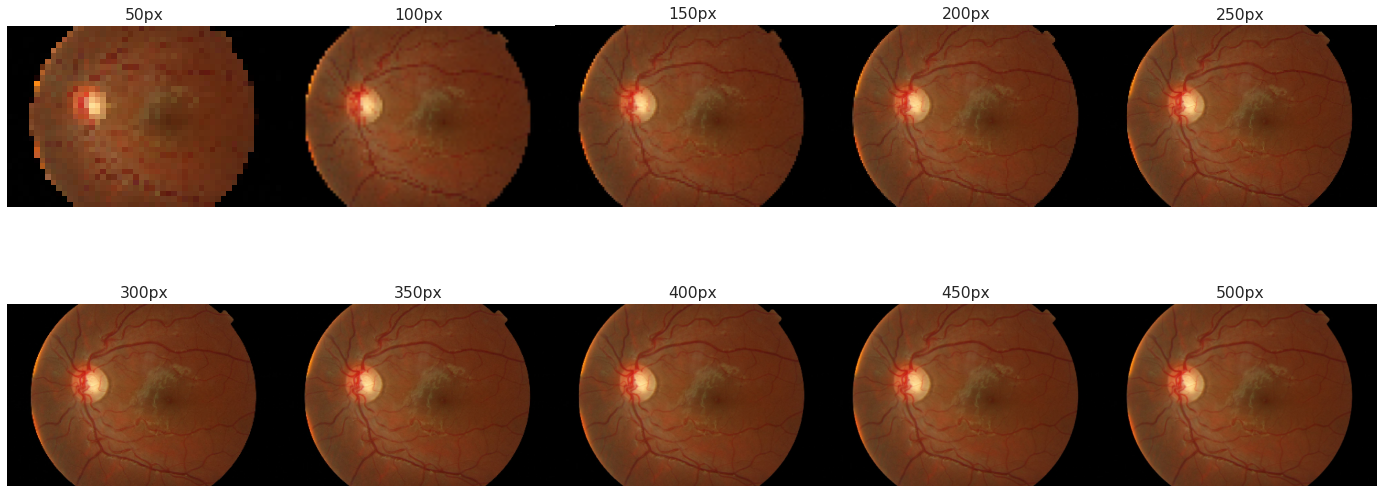

In [ ]:
img = tf.io.decode_image(tf.io.read_file(os.path.join(DSET_IMAGES, 'IM004812.JPG')))
img = tf.image.central_crop(img, 0.75)

fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.tight_layout()
plt.subplots_adjust(top=0.4, wspace=0)
ind = 1
for row in axes:
    for ax in row:
        ax.grid('off')
        ax.axis('off')
        ax.set_title(f'{50 * ind}px')
        ax.imshow(tf.image.resize(img, [50 * ind, 50 * ind], method='nearest', preserve_aspect_ratio=True))
        ind += 1

### 4 Model Selection

In [ ]:
%load_ext tensorboard

In [ ]:
# Callbacks
class ExpoIncreaseLRCallback(keras.callbacks.Callback):
    """
    Exponentially increases the learning rate by a constant factor. Meant to
    be run over a few hundred iterations in one epoch. Stores a history object
    of the loss and the learning rates. The optimal loss is usually about 10x
    lower than when the algorithm diverges (loss shoots up).
    """
    def __init__(self, factor): 
        super().__init__()
        self.loss = []
        self.lr = []
        self.factor = factor
        
    def on_batch_end(self, batch, logs=None):
        loss = logs['loss']
        prev_lr = K.get_value(self.model.optimizer.lr)
        self.lr.append(prev_lr)
        self.loss.append(loss)
        K.set_value(self.model.optimizer.lr, prev_lr * self.factor)

class OneCycleScheduler(keras.callbacks.Callback):
    """
    Learning rate scheduler, implementing a cyclical learning rate (Smith, 2018).
    https://arxiv.org/abs/1803.09820 
    """
    def __init__(self, epoch_size, batch_size, max_lr, max_momentum=0, min_momentum=0):
        super(OneCycleScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = max_lr / 10
        self.progress = 0
        self.iterations = epoch_size // batch_size
        self.max_momentum = max_momentum
        self.min_momentum = min_momentum
        
    def on_epoch_begin(self, epoch, logs=None):
        keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        keras.backend.set_value(self.model.optimizer.momentum, self.max_momentum)
        self.progress = 0
    
    def on_train_batch_begin(self, batch, logs=None):
        self.progress += 1
        
        # Finding rate of change to halfway through epoch
        half = self.iterations // 2 
        lr_roc = (self.max_lr - self.min_lr) / half
        
        # Increase if first half, else decrease
        if self.progress >= half:
            lr_roc *= -1
        lr = self.model.optimizer.lr
        cur_lr = lr + lr_roc
        keras.backend.set_value(self.model.optimizer.lr, cur_lr)
        
        # Finding rate of change for momentum
        momentum_roc = -((self.max_momentum - self.min_momentum) / half)
        
        # Decrease if first half, else decrease
        if self.progress >= half:
            momentum_roc *= -1
        momentum = self.model.optimizer.momentum
        cur_momentum = momentum + momentum_roc
        keras.backend.set_value(self.model.optimizer.momentum, cur_momentum)

Class proportions: Healthy: 0.4779491833030853, DR: 0.23439201451905625, Glaucoma: 0.05172413793103448, Cataracts: 0.02223230490018149, AMD: 0.03457350272232305, Hypertension: 0.01442831215970962 Myopia: 0.04528130671506352, Other: 0.17286751361161526


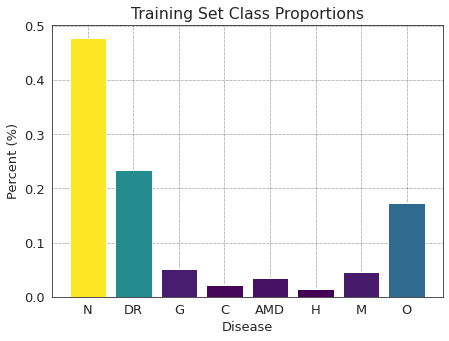

In [ ]:
classes_numbers = tf.reduce_sum(y_train, axis=0)
classes = classes_numbers / y_train.shape[0]
print(f'Class proportions: Healthy: {classes[0]}, DR: {classes[1]}, Glaucoma: {classes[2]}, Cataracts: {classes[3]}, AMD: {classes[4]}, Hypertension: {classes[5]} Myopia: {classes[6]}, Other: {classes[7]}')
plt.bar(dset.columns[2:], classes, color=viridis(rescale(class_proportions)))
plt.title('Training Set Class Proportions')
plt.xlabel('Disease')
ylabel = plt.ylabel('Percent (%)')

In [ ]:
# Callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)

In [ ]:
# VGGNet
K.clear_session()
tf.random.set_seed(42)
random.seed(42)

def make_vgg_net():
    """
    Implementation of the 2015 ILSVRC second place VGGNet-19 architecture.
    Note that the placement of the batch normalization layers in front of
    the activation was purposeful. There is some debate regarding whether
    or not the placement of BN before or after ReLU has any large effect
    on performance.
    """
    augmentation = keras.models.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    ])
    normalization = keras.layers.experimental.preprocessing.Normalization()
    for batch in train_dataset.take(3):
        img = batch[0]
        normalization.adapt(img)

    model = keras.models.Sequential([
        augmentation,
        normalization,
        keras.layers.Conv2D(64, 3, padding="same", input_shape=[244, 244, 3]),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
        keras.layers.Conv2D(256, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, 3, padding="same"),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
        keras.layers.Flatten(),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(4096, kernel_initializer='he_normal'),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(4096, kernel_initializer='he_normal'),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(1000, kernel_initializer='he_normal'),
        keras.layers.Activation('relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(8, activation="sigmoid")
    ])
    return model
model = make_vgg_net()
# Using Nadam for fast convergence and minimal hyperparameter tuning
model.compile(optimizer=keras.optimizers.Nadam(lr=3e-4), metrics=['binary_accuracy', 'AUC'], loss='binary_crossentropy')
model.build(input_shape=(None, 244, 244, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 244, 244, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 244, 244, 3)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 244, 244, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 244, 244, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 244, 244, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 244, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 244, 244, 64)     

In [ ]:
# Training the custom VGGNet
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/custom_vggnet19.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
csv_logger_cb =tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/custom_vggnet19.csv', separator=",", append=False)

history = model.fit(
    train_dataset, epochs=1000, validation_data=val_dataset,
    callbacks=[tensorboard_cb, model_checkpoint_cb, early_stopping_cb, csv_logger_cb])

Epoch 1/1000
345/345 [==============================] - 154s 414ms/step - loss: 0.7011 - binary_accuracy: 0.6491 - auc: 0.6054 - val_loss: 0.4271 - val_binary_accuracy: 0.8631 - val_auc: 0.7527
Epoch 2/1000
345/345 [==============================] - 140s 404ms/step - loss: 0.2927 - binary_accuracy: 0.8814 - auc: 0.8501 - val_loss: 0.3969 - val_binary_accuracy: 0.8359 - val_auc: 0.7647
Epoch 3/1000
345/345 [==============================] - 140s 405ms/step - loss: 0.2670 - binary_accuracy: 0.8863 - auc: 0.8776 - val_loss: 0.3227 - val_binary_accuracy: 0.8706 - val_auc: 0.8539
Epoch 4/1000
345/345 [==============================] - 140s 404ms/step - loss: 0.2624 - binary_accuracy: 0.8878 - auc: 0.8826 - val_loss: 0.2944 - val_binary_accuracy: 0.8750 - val_auc: 0.8553
Epoch 5/1000
345/345 [==============================] - 140s 404ms/step - loss: 0.2586 - binary_accuracy: 0.8889 - auc: 0.8876 - val_loss: 0.2609 - val_binary_accuracy: 0.8846 - val_auc: 0.8880
Epoch 6/1000
345/345 [========

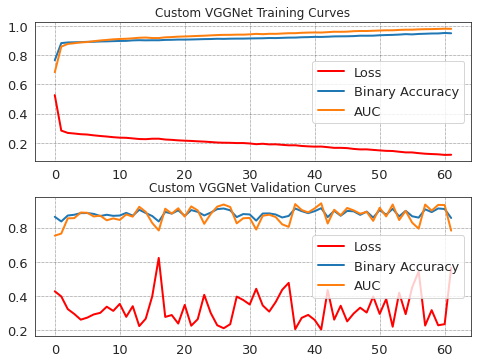

In [ ]:
# Plotting custom VGGNet learning curves
learning_curves = pd.DataFrame(history.history)
    
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
fig.tight_layout()

axes[0].plot(learning_curves['loss'], label='Loss', color='red')
axes[0].plot(learning_curves['binary_accuracy'], label='Binary Accuracy')
axes[0].plot(learning_curves['auc'], label='AUC')
axes[0].set_title('Custom VGGNet Training Curves')
axes[0].legend()


axes[1].plot(learning_curves['val_loss'], label='Loss', color='red')
axes[1].plot(learning_curves['val_binary_accuracy'], label='Binary Accuracy')
axes[1].plot(learning_curves['val_auc'], label='AUC')
axes[1].set_title('Custom VGGNet Validation Curves')
axes[1].legend()

In [ ]:
# Code for model predictions
def create_confusion_matrix(y_true, y_pred, names):
    confusion = multilabel_confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.tight_layout()
    axes = axes.ravel()

    for ind, ax in enumerate(axes):
        confusion_display = ConfusionMatrixDisplay(confusion[ind], display_labels=[0, 1])
        confusion_display.plot(ax=ax, values_format='.5g')
        ax.set_title(names[ind])

def _to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def get_thresholds(model, dataset, samples=1):
    y_prob = np.stack([model.predict(dataset) for sample in range(samples)]).mean(axis=0)
    y_true = []
    for ind, batch in enumerate(dataset):
        y_true.append(batch[1])
    
    y_true = tf.concat(y_true, 0)
    thresholds = np.arange(0, 1, 0.001)
    class_thresholds = []

    for i in range(8):
        scores = [f1_score(y_true[:, i], _to_labels(y_prob[:, i], t)) for t in thresholds] 
        ix = np.argmax(scores)
        class_thresholds.append(thresholds[ix])

    return class_thresholds

def get_predictions(model, class_thresholds, dataset, samples=1):
    y_prob = np.stack([model.predict(dataset) for sample in range(samples)]).mean(axis=0)
    y_true = []
    for ind, batch in enumerate(dataset):
        y_true.append(batch[1])
    
    y_true = tf.concat(y_true, 0)
    y_pred = []
    for ind, thresh in enumerate(class_thresholds):
        class_pred = np.where(y_prob[:, ind] > thresh, 1, 0)
        y_pred.append(tf.reshape(class_pred, (-1, 1)))
    y_pred = tf.concat(y_pred, 1)
    return y_true, y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.66      0.92      0.77       665
           1       0.53      0.68      0.60       343
           2       0.28      0.64      0.39        70
           3       0.75      0.63      0.69        38
           4       0.32      0.43      0.37        46
           5       0.30      0.15      0.20        20
           6       0.78      0.61      0.68        51
           7       0.63      0.60      0.62       231

   micro avg       0.59      0.76      0.66      1464
   macro avg       0.53      0.58      0.54      1464
weighted avg       0.60      0.76      0.66      1464
 samples avg       0.63      0.77      0.67      1464

0.7389520593864938


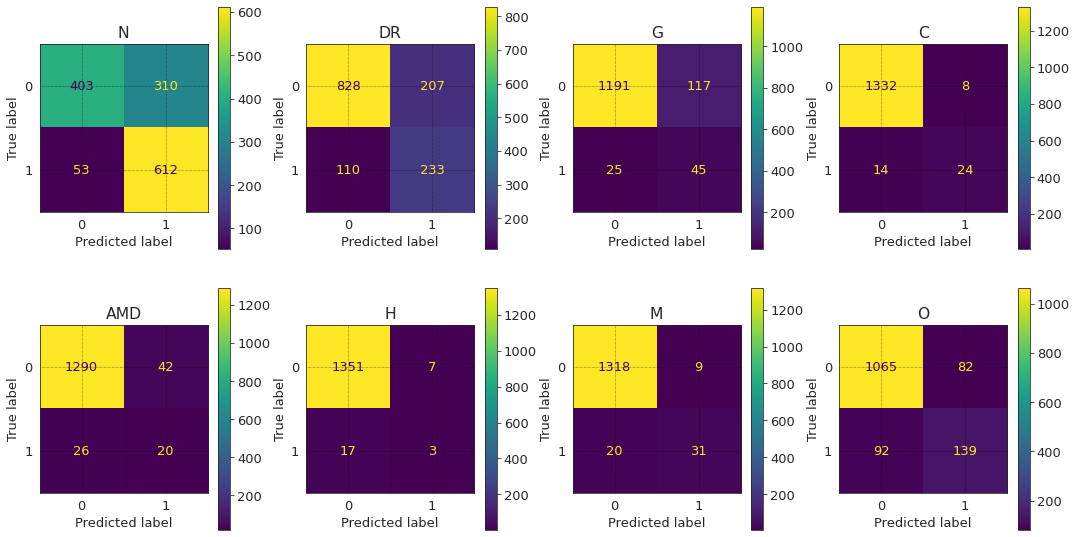

In [ ]:
# Custom VGGNet error analysis
model = keras.models.load_model('/content/drive/MyDrive/models/custom_vggnet19.h5')
thresholds = get_thresholds(model, val_dataset)        
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
create_confusion_matrix(y_true, y_pred, dset.columns[2:])

In [ ]:
# VGGNet, same architecture, instead using SGD
K.clear_session()
tf.random.set_seed(42)
random.seed(42)

# Finding the optimial learning rate
expo_lr = ExpoIncreaseLRCallback(1.032)
model = make_vgg_net()
model.compile(optimizer=keras.optimizers.SGD(lr=0.0001), metrics=['binary_accuracy', 'AUC'], loss='binary_crossentropy')
model.fit(train_dataset, epochs=1, callbacks=[expo_lr])

345/345 [==============================] - 124s 349ms/step - loss: 0.8743 - binary_accuracy: 0.5266 - auc: 0.5227


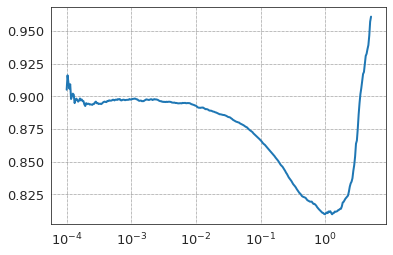

In [ ]:
plt.plot(expo_lr.lr, expo_lr.loss)
plt.xscale('log')

0.11 seems to be a good learning rate. We can use this as the maximum learning rate for our cyclical learning rate scheduler.

In [ ]:
model = make_vgg_net()

# Callbacks
one_cycle_scheduler = OneCycleScheduler(11020, 32, 0.11)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/SGD_vggnet19.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
csv_logger_cb =tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/SGD_vggnet19.csv', separator=",", append=False)

optimizer = keras.optimizers.SGD(lr=0.11)
model.compile(optimizer=optimizer, metrics=['binary_accuracy', 'AUC'], loss='binary_crossentropy')
history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                    callbacks=[one_cycle_scheduler, tensorboard_cb, model_checkpoint_cb, early_stopping_cb, csv_logger_cb])

Epoch 1/1000
      6/Unknown - 6s 490ms/step - loss: 0.9163 - binary_accuracy: 0.4919 - auc: 0.4695WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2083s vs `on_train_batch_end` time: 0.2365s). Check your callbacks.
345/345 [==============================] - 129s 366ms/step - loss: 0.7087 - binary_accuracy: 0.6207 - auc: 0.5787 - val_loss: 0.2945 - val_binary_accuracy: 0.8834 - val_auc: 0.8558
Epoch 2/1000
345/345 [==============================] - 125s 362ms/step - loss: 0.3258 - binary_accuracy: 0.8664 - auc: 0.8030 - val_loss: 0.2621 - val_binary_accuracy: 0.8892 - val_auc: 0.8844
Epoch 3/1000
345/345 [==============================] - 125s 362ms/step - loss: 0.2955 - binary_accuracy: 0.8740 - auc: 0.8423 - val_loss: 0.2564 - val_binary_accuracy: 0.8882 - val_auc: 0.8901
Epoch 4/1000
345/345 [==============================] - 125s 362ms/step - loss: 0.2824 - binary_accuracy: 0.8792 - auc: 0.8588 - val_loss: 0.2872 - val_binary

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      0.85      0.77       665
           1       0.72      0.47      0.57       343
           2       0.58      0.27      0.37        70
           3       0.64      0.66      0.65        38
           4       0.46      0.26      0.33        46
           5       0.40      0.10      0.16        20
           6       0.81      0.69      0.74        51
           7       0.61      0.66      0.63       231

   micro avg       0.68      0.66      0.67      1464
   macro avg       0.62      0.49      0.53      1464
weighted avg       0.68      0.66      0.66      1464
 samples avg       0.65      0.68      0.66      1464

0.7146272959489597


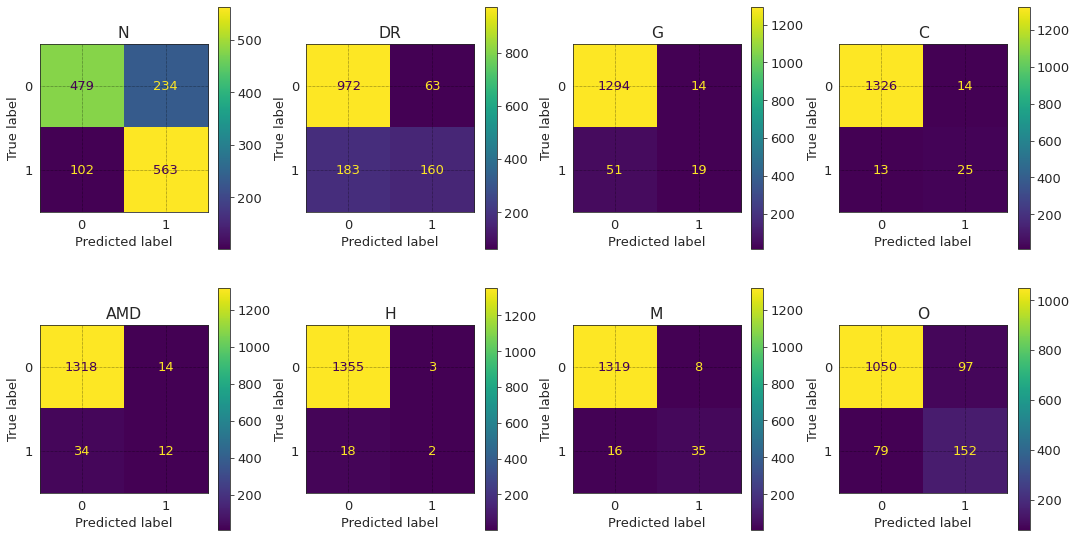

In [ ]:
# Slightly better generalization error, however very slow to train
# Better at determining the minority classes
# Test performance without adjusting thresholds
model = keras.models.load_model('/content/drive/MyDrive/models/SGD_vggnet19.h5')
y_pred = model.predict(test_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0)

y_true = 0
for ind, batch in enumerate(test_dataset):
    if ind == 0:
        y_true = batch[1]
    else:
        y_true = np.vstack([y_true, batch[1]])

create_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      0.85      0.77       665
           1       0.53      0.77      0.63       343
           2       0.31      0.61      0.41        70
           3       0.68      0.55      0.61        38
           4       0.39      0.48      0.43        46
           5       0.00      0.00      0.00        20
           6       0.73      0.73      0.73        51
           7       0.46      0.81      0.58       231

   micro avg       0.57      0.78      0.66      1464
   macro avg       0.47      0.60      0.52      1464
weighted avg       0.58      0.78      0.66      1464
 samples avg       0.62      0.79      0.68      1464

0.744902521151094


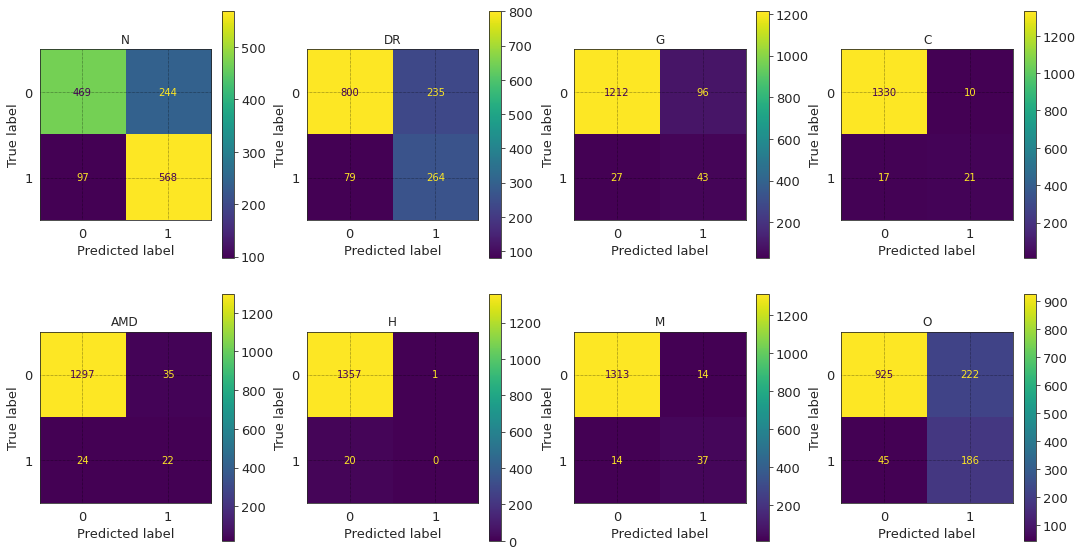

In [ ]:
# Using thresholds calculated on the validation set
model = keras.models.load_model('/content/drive/MyDrive/models/SGD_vggnet19.h5')

thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
create_confusion_matrix(y_true, y_pred, dset.columns[2:])
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))

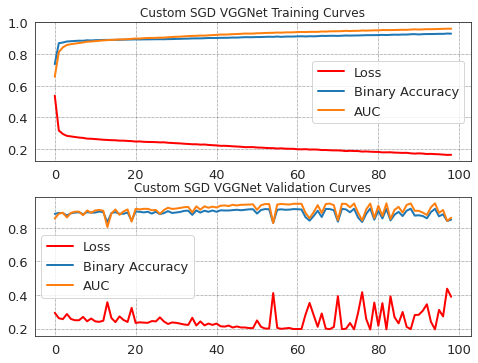

In [ ]:
# Plotting custom VGGNet learning curves
learning_curves = pd.read_csv('/content/drive/MyDrive/learning_curves/SGD_vggnet19.csv')

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
fig.tight_layout()

axes[0].plot(learning_curves['loss'], label='Loss', color='red')
axes[0].plot(learning_curves['binary_accuracy'], label='Binary Accuracy')
axes[0].plot(learning_curves['auc'], label='AUC')
axes[0].set_title('Custom SGD VGGNet Training Curves')
axes[0].legend()


axes[1].plot(learning_curves['val_loss'], label='Loss', color='red')
axes[1].plot(learning_curves['val_binary_accuracy'], label='Binary Accuracy')
axes[1].plot(learning_curves['val_auc'], label='AUC')
axes[1].set_title('Custom SGD VGGNet Validation Curves')
axes[1].legend()

In [ ]:
# Implementing a custom ResNet with Squeeze and Excitation blocks
class SEResidualUnit(keras.layers.Layer):
    """
    The residual units with skip connections
    """
    def __init__(self, filters, ratio=8, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.strides = strides
        # The main layers of the residual unit, two convolutional layers,
        # one with a stride of one and batch normalization layers
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
        ]

        # Defining the skip connection and the convolutional layer the inputs
        # have to pass through so as to ensure the shapes of added inputs are
        # the same as those going through the main layer
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding='same', use_bias=False),
                keras.layers.BatchNormalization()
            ]

        # SE Block
        self.ratio = ratio
        self.se_block = [
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(filters//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False),
            keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False),
        ]

    def call(self, inputs):
        """
        Adding the inputs from the skip connection to the outputs and passing
        output of Residual Unit to SE block.
        """
        # Residual unit
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        # SE Block
        X = Z
        for layer in self.se_block:
            X = layer(X)
        Z = keras.layers.multiply([X, Z]) 

        # Skip connection
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        out = self.activation(Z + skip_Z)
        return out

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'filters': self.filters, 'strides': self.strides,
         'activation': keras.activations.serialize(self.activation), 'ratio': self.ratio}

# ResNet architecture
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
def create_resnet():
    augmentation = keras.models.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    ])
    model = keras.models.Sequential()
    model.add(augmentation)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=(244, 244, 3),
                        padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(2))
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if prev_filters == filters else 2
        model.add(SEResidualUnit(filters, strides=strides, activation='relu'))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1000, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(8, activation='sigmoid'))
    return model

model = create_resnet()
model.build(input_shape=[None, 244, 244, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 244, 244, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 244, 244, 3)       12        
_________________________________________________________________
activation (Activation)      (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 122, 122, 64)      9408      
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 122, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 122, 122, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 64)       

In [ ]:
# Finding optmial learning rate
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
one_cycle = OneCycleScheduler(11020, 32, 0.4)
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
expo_lr = ExpoIncreaseLRCallback(1.05)
model = create_resnet()
model.compile(optimizer=keras.optimizers.SGD(lr=0.4), loss='binary_crossentropy', metrics=['binary_accuracy', precision, recall, 'AUC'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[one_cycle])

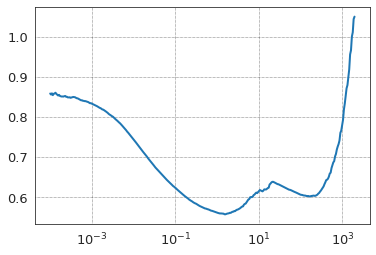

In [ ]:
plt.plot(expo_lr.lr, expo_lr.loss)
plt.xscale('log')

In [ ]:
# Training SE-Resnet-34 model
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
model = create_resnet()

one_cycle = OneCycleScheduler(11020, 32, 0.4)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models/SE_resnet34.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
csv_logger_cb = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/SE_resnet34_no_class_weights.csv', separator=",", append=False)

precision = keras.metrics.Precision()
recall = keras.metrics.Recall()

model.compile(optimizer=keras.optimizers.SGD(lr=0.4), loss='binary_crossentropy', metrics=['binary_accuracy', precision, recall, 'AUC'])
history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                    callbacks=[one_cycle, model_checkpoint_cb, early_stopping_cb, csv_logger_cb, tensorboard_cb])

Epoch 1/1000
      6/Unknown - 8s 269ms/step - loss: 0.6427 - binary_accuracy: 0.6342 - precision: 0.1122 - recall: 0.2423 - auc: 0.4711WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0598s vs `on_train_batch_end` time: 0.1313s). Check your callbacks.
345/345 [==============================] - 35s 84ms/step - loss: 0.3616 - binary_accuracy: 0.8506 - precision: 0.4138 - recall: 0.2332 - auc: 0.7666 - val_loss: 0.2862 - val_binary_accuracy: 0.8723 - val_precision: 0.5179 - val_recall: 0.4397 - val_auc: 0.8584
Epoch 2/1000
345/345 [==============================] - 27s 78ms/step - loss: 0.2962 - binary_accuracy: 0.8740 - precision: 0.5412 - recall: 0.2782 - auc: 0.8476 - val_loss: 0.2717 - val_binary_accuracy: 0.8809 - val_precision: 0.5722 - val_recall: 0.3797 - val_auc: 0.8725
Epoch 3/1000
345/345 [==============================] - 27s 78ms/step - loss: 0.2871 - binary_accuracy: 0.8774 - precision: 0.5580 - recall: 0.3282 - auc: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.63      0.84      0.72       665
           1       0.57      0.52      0.54       343
           2       0.26      0.63      0.37        70
           3       0.65      0.39      0.49        38
           4       0.19      0.41      0.26        46
           5       0.50      0.10      0.17        20
           6       0.62      0.59      0.61        51
           7       0.44      0.70      0.54       231

   micro avg       0.53      0.69      0.60      1464
   macro avg       0.48      0.52      0.46      1464
weighted avg       0.55      0.69      0.60      1464
 samples avg       0.57      0.71      0.61      1464

0.7018193528172416


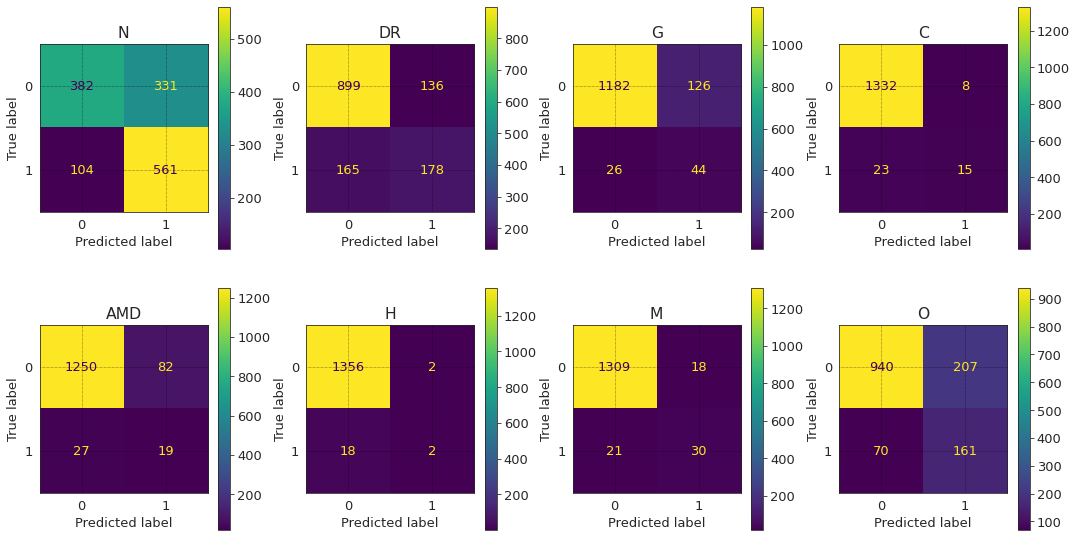

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/models/SE_resnet34.h5',
    custom_objects={'SEResidualUnit': SEResidualUnit}
)
thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
create_confusion_matrix(y_true, y_pred)

In [ ]:
# Training SE-Resnet-34 model with Nadam
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
model = create_resnet()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models/Nadam_SE_resnet34.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30)
csv_logger_cb = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/SE_resnet34_Nadam.csv', separator=",", append=True)

precision = keras.metrics.Precision()
recall = keras.metrics.Recall()

model.compile(optimizer=keras.optimizers.Nadam(lr=3e-4), loss='binary_crossentropy', metrics=['binary_accuracy', precision, recall, 'AUC'])
history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, csv_logger_cb, tensorboard_cb])

Epoch 1/1000
345/345 [==============================] - 33s 95ms/step - loss: 0.1403 - binary_accuracy: 0.9407 - precision: 0.8097 - recall: 0.7187 - auc: 0.9709 - val_loss: 0.2442 - val_binary_accuracy: 0.8999 - val_precision: 0.6399 - val_recall: 0.5486 - val_auc: 0.9176
Epoch 2/1000
345/345 [==============================] - 32s 93ms/step - loss: 0.1424 - binary_accuracy: 0.9400 - precision: 0.8036 - recall: 0.7206 - auc: 0.9696 - val_loss: 0.2448 - val_binary_accuracy: 0.8985 - val_precision: 0.6312 - val_recall: 0.5520 - val_auc: 0.9190
Epoch 3/1000
345/345 [==============================] - 32s 91ms/step - loss: 0.1415 - binary_accuracy: 0.9409 - precision: 0.8093 - recall: 0.7207 - auc: 0.9699 - val_loss: 0.2508 - val_binary_accuracy: 0.9020 - val_precision: 0.6485 - val_recall: 0.5582 - val_auc: 0.9165
Epoch 4/1000
345/345 [==============================] - 32s 91ms/step - loss: 0.1358 - binary_accuracy: 0.9428 - precision: 0.8189 - recall: 0.7264 - auc: 0.9727 - val_loss: 0.26

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.65      0.84      0.73       665
           1       0.45      0.73      0.56       343
           2       0.26      0.59      0.36        70
           3       0.72      0.47      0.57        38
           4       0.32      0.37      0.34        46
           5       0.29      0.10      0.15        20
           6       0.58      0.59      0.58        51
           7       0.57      0.57      0.57       231

   micro avg       0.54      0.71      0.62      1464
   macro avg       0.48      0.53      0.48      1464
weighted avg       0.56      0.71      0.62      1464
 samples avg       0.58      0.73      0.63      1464

0.7072504047948096


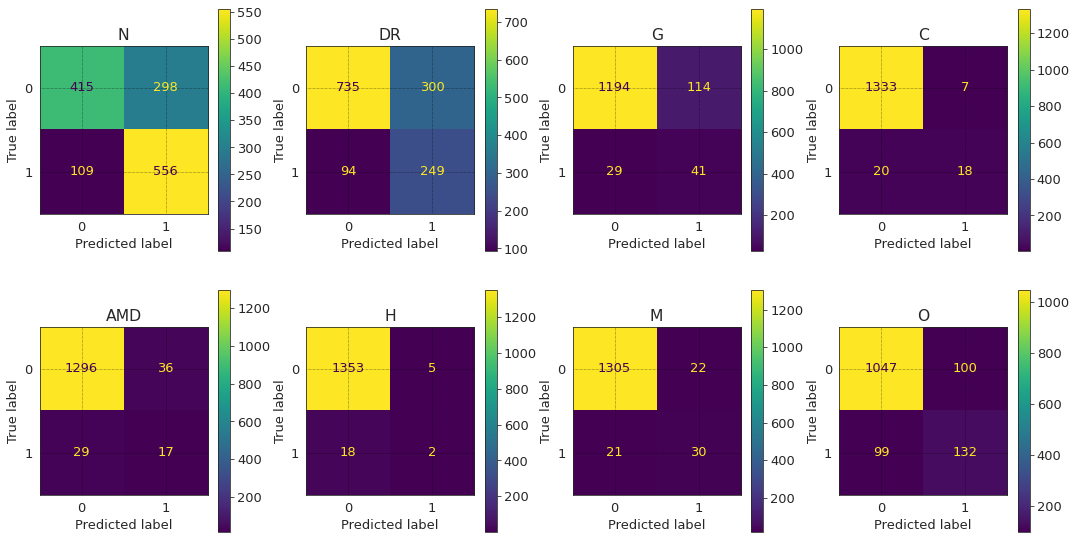

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/models/Nadam_SE_resnet34.h5',
    custom_objects={'SEResidualUnit': SEResidualUnit}
)

thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
create_confusion_matrix(y_true, y_pred)

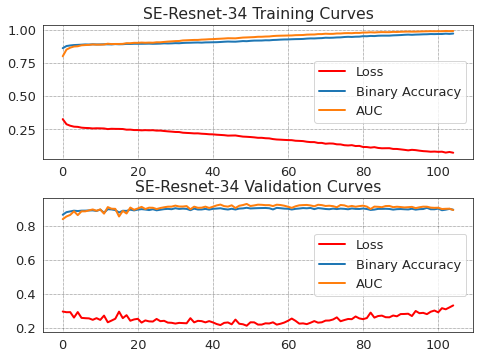

In [ ]:
learning_curves = pd.read_csv('/content/drive/MyDrive/learning_curves/SE_resnet34_Nadam.csv')

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
fig.tight_layout()

axes[0].plot(learning_curves['loss'], label='Loss', color='red')
axes[0].plot(learning_curves['binary_accuracy'], label='Binary Accuracy')
axes[0].plot(learning_curves['auc'], label='AUC')
axes[0].set_title('SE-Resnet-34 Training Curves')
axes[0].legend()


axes[1].plot(learning_curves['val_loss'], label='Loss', color='red')
axes[1].plot(learning_curves['val_binary_accuracy'], label='Binary Accuracy')
axes[1].plot(learning_curves['val_auc'], label='AUC')
axes[1].set_title('SE-Resnet-34 Validation Curves')
axes[1].legend()

              precision    recall  f1-score   support

           0       0.65      0.85      0.73       665
           1       0.41      0.80      0.54       343
           2       0.28      0.53      0.36        70
           3       0.70      0.50      0.58        38
           4       0.19      0.61      0.29        46
           5       0.50      0.10      0.17        20
           6       0.68      0.71      0.69        51
           7       0.46      0.62      0.53       231

   micro avg       0.50      0.75      0.60      1464
   macro avg       0.48      0.59      0.49      1464
weighted avg       0.53      0.75      0.61      1464
 samples avg       0.56      0.77      0.63      1464

0.7231426226923694


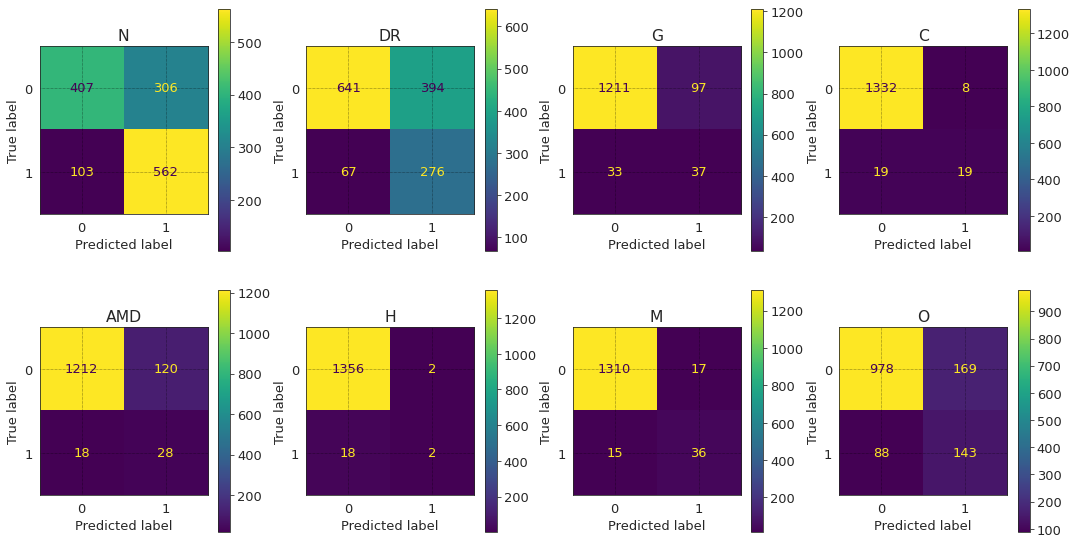

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/models/Nadam_SE_resnet34_longer_train.h5',
    custom_objects={'SEResidualUnit': SEResidualUnit}
)

thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
create_confusion_matrix(y_true, y_pred, dset.columns[2:])

In [ ]:
# Computing class weights
totals = tf.reduce_sum(y_train, axis=0).numpy()
labels = []
for ind, val in enumerate(totals):
    labels.extend([ind] * val)
class_weights = compute_class_weight('balanced', np.arange(8), labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.27551262578317826,
 1: 0.5617982965543941,
 2: 2.5458333333333334,
 3: 5.922959183673469,
 4: 3.808727034120735,
 5: 9.126572327044025,
 6: 2.908066132264529,
 7: 0.7617454068241469}

In [ ]:
# Training a class weighted SE_Resnet
K.clear_session()
tf.random.set_seed(42)
random.seed(42)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/SE_resnet34_class_weights.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
csv_logger_cb = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/SE_resnet34_class_weights.csv', separator=",", append=False)
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
model.compile(optimizer=keras.optimizers.Nadam(lr=3e-4), metrics=['binary_accuracy', precision, recall, 'AUC'], loss='binary_crossentropy')
history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                    callbacks=[tensorboard_cb, model_checkpoint_cb, early_stopping_cb, csv_logger_cb], class_weight=class_weights)

Epoch 1/1000
345/345 [==============================] - 68s 104ms/step - loss: 0.4138 - binary_accuracy: 0.8262 - precision: 0.1195 - recall: 0.0449 - auc: 0.5364 - val_loss: 0.3470 - val_binary_accuracy: 0.8683 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7915
Epoch 2/1000
345/345 [==============================] - 33s 95ms/step - loss: 0.3513 - binary_accuracy: 0.8617 - precision: 0.2672 - recall: 0.0289 - auc: 0.6711 - val_loss: 0.3686 - val_binary_accuracy: 0.8668 - val_precision: 0.4604 - val_recall: 0.0641 - val_auc: 0.7001
Epoch 3/1000
345/345 [==============================] - 32s 93ms/step - loss: 0.3346 - binary_accuracy: 0.8630 - precision: 0.3722 - recall: 0.0589 - auc: 0.7043 - val_loss: 0.3522 - val_binary_accuracy: 0.8698 - val_precision: 0.5649 - val_recall: 0.0510 - val_auc: 0.7308
Epoch 4/1000
345/345 [==============================] - 32s 93ms/step - loss: 0.3234 - binary_accuracy: 0.8631 - precision: 0.3856 - recall: 0.0666 - auc: 0.7223 - val_l

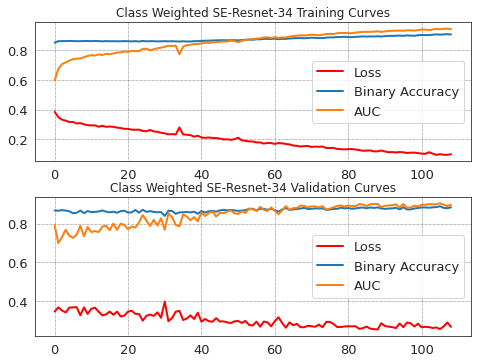

In [ ]:
# Class-weighted SE-Resnet-34 learning curves
learning_curves = pd.DataFrame(history.history)
    
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
fig.tight_layout()

axes[0].plot(learning_curves['loss'], label='Loss', color='red')
axes[0].plot(learning_curves['binary_accuracy'], label='Binary Accuracy')
axes[0].plot(learning_curves['auc'], label='AUC')
axes[0].set_title('Class Weighted SE-Resnet-34 Training Curves')
axes[0].legend()


axes[1].plot(learning_curves['val_loss'], label='Loss', color='red')
axes[1].plot(learning_curves['val_binary_accuracy'], label='Binary Accuracy')
axes[1].plot(learning_curves['val_auc'], label='AUC')
axes[1].set_title('Class Weighted SE-Resnet-34 Validation Curves')
axes[1].legend()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.86      0.70       665
           1       0.42      0.75      0.54       343
           2       0.25      0.46      0.32        70
           3       0.66      0.71      0.68        38
           4       0.27      0.22      0.24        46
           5       0.04      0.05      0.05        20
           6       0.64      0.69      0.66        51
           7       0.45      0.63      0.52       231

   micro avg       0.49      0.73      0.59      1464
   macro avg       0.42      0.54      0.46      1464
weighted avg       0.50      0.73      0.59      1464
 samples avg       0.53      0.75      0.60      1464

0.6984394212496483


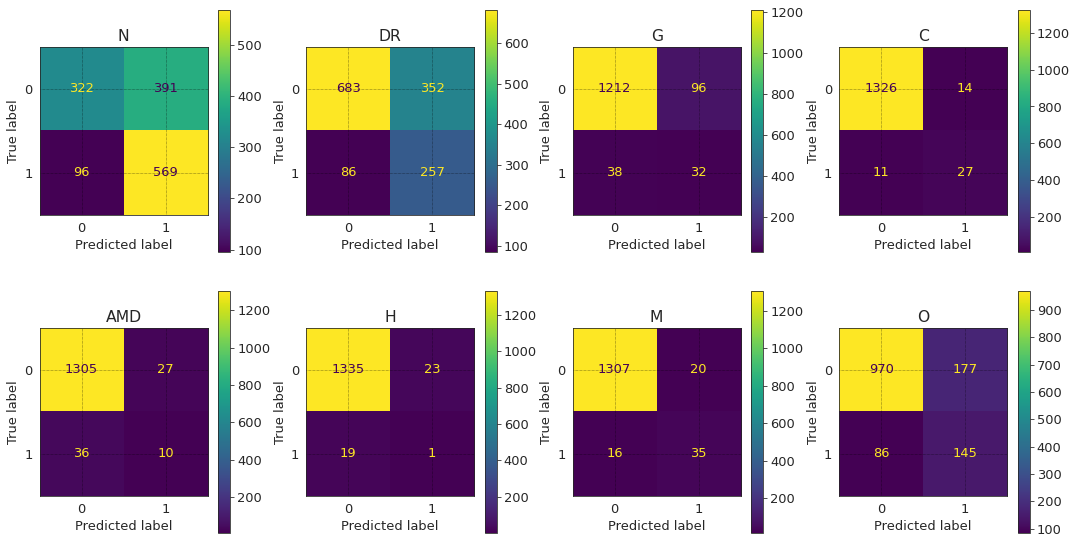

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/models/SE_resnet34_class_weights.h5',
    custom_objects={'SEResidualUnit': SEResidualUnit}
)
thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))
create_confusion_matrix(y_true, y_pred)

In [ ]:
# Testing oversampling, creating balanced classes with copies of minority
# classes with data augmentation
dset_train_oversample = os.path.join(os.curdir, './records_over1000/dset_train.tfrecord')
train_dataset_oversample = tf.data.TFRecordDataset(dset_train_oversample, compression_type='GZIP').shuffle(2048)
train_dataset_oversample = train_dataset_oversample.map(_parse_dataset, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

In [ ]:
# Training an SE-Resnet-34 on the oversampled dataset
K.clear_session()
tf.random.set_seed(42)
random.seed(42)
one_cycle = OneCycleScheduler(11020, 32, 0.4)
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
expo_lr = ExpoIncreaseLRCallback(1.035)
model = create_resnet()
model.compile(optimizer=keras.optimizers.Nadam(lr=3e-4), loss='binary_crossentropy', metrics=['binary_accuracy', precision, recall, 'AUC'])
history = model.fit(train_dataset_oversample, epochs=10, validation_data=val_dataset)

Epoch 1/10
462/462 [==============================] - 63s 98ms/step - loss: 0.3831 - binary_accuracy: 0.8309 - precision: 0.4381 - recall: 0.2531 - auc: 0.7544 - val_loss: 1.0146 - val_binary_accuracy: 0.8690 - val_precision: 0.5062 - val_recall: 0.2240 - val_auc: 0.6310
Epoch 2/10
462/462 [==============================] - 45s 96ms/step - loss: 0.3063 - binary_accuracy: 0.8724 - precision: 0.6546 - recall: 0.2842 - auc: 0.8454 - val_loss: 1.7047 - val_binary_accuracy: 0.8591 - val_precision: 0.4313 - val_recall: 0.2185 - val_auc: 0.6398
Epoch 3/10
462/462 [==============================] - 45s 96ms/step - loss: 0.3111 - binary_accuracy: 0.8716 - precision: 0.6623 - recall: 0.2652 - auc: 0.8404 - val_loss: 0.8439 - val_binary_accuracy: 0.8477 - val_precision: 0.2505 - val_recall: 0.0786 - val_auc: 0.7323
Epoch 4/10
462/462 [==============================] - 45s 96ms/step - loss: 0.3089 - binary_accuracy: 0.8710 - precision: 0.6571 - recall: 0.2592 - auc: 0.8428 - val_loss: 0.5500 - val

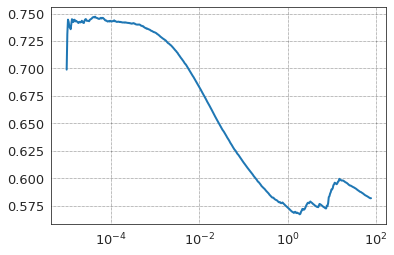

In [ ]:
plt.plot(expo_lr.lr, expo_lr.loss)
plt.xscale('log')

In [ ]:
K.clear_session()
tf.random.set_seed(42)
random.seed(42)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/SE_resnet34_oversample.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
csv_logger_cb =tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/learning_curves/SE_resnet34_oversample.csv', separator=",", append=False)
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
model.compile(optimizer=keras.optimizers.Nadam(lr=3e-4), metrics=[precision, recall, 'AUC'], loss='binary_crossentropy')
history = model.fit(train_dataset_oversample, epochs=1000, validation_data=val_dataset,
                    callbacks=[tensorboard_cb, model_checkpoint_cb, early_stopping_cb, csv_logger_cb])

Epoch 1/1000
462/462 [==============================] - 66s 104ms/step - loss: 0.2808 - precision: 0.6699 - recall: 0.3819 - auc: 0.8781 - val_loss: 0.3244 - val_precision: 0.4446 - val_recall: 0.1937 - val_auc: 0.8156
Epoch 2/1000
462/462 [==============================] - 45s 96ms/step - loss: 0.2623 - precision: 0.7190 - recall: 0.4201 - auc: 0.8932 - val_loss: 0.3067 - val_precision: 0.4455 - val_recall: 0.0620 - val_auc: 0.8261
Epoch 3/1000
462/462 [==============================] - 45s 96ms/step - loss: 0.2812 - precision: 0.7000 - recall: 0.3500 - auc: 0.8739 - val_loss: 0.7961 - val_precision: 0.0909 - val_recall: 0.0889 - val_auc: 0.5892
Epoch 4/1000
462/462 [==============================] - 44s 95ms/step - loss: 0.2778 - precision: 0.6903 - recall: 0.3827 - auc: 0.8788 - val_loss: 0.3486 - val_precision: 0.4588 - val_recall: 0.2343 - val_auc: 0.7987
Epoch 5/1000
462/462 [==============================] - 44s 95ms/step - loss: 0.2923 - precision: 0.6957 - recall: 0.3022 - auc

              precision    recall  f1-score   support

           0       0.53      0.95      0.68       665
           1       0.35      0.78      0.48       343
           2       0.18      0.20      0.19        70
           3       0.11      0.13      0.12        38
           4       0.09      0.09      0.09        46
           5       0.08      0.30      0.13        20
           6       0.26      0.35      0.30        51
           7       0.48      0.35      0.40       231

   micro avg       0.42      0.70      0.53      1464
   macro avg       0.26      0.39      0.30      1464
weighted avg       0.42      0.70      0.51      1464
 samples avg       0.46      0.72      0.54      1464

0.6002533177652272


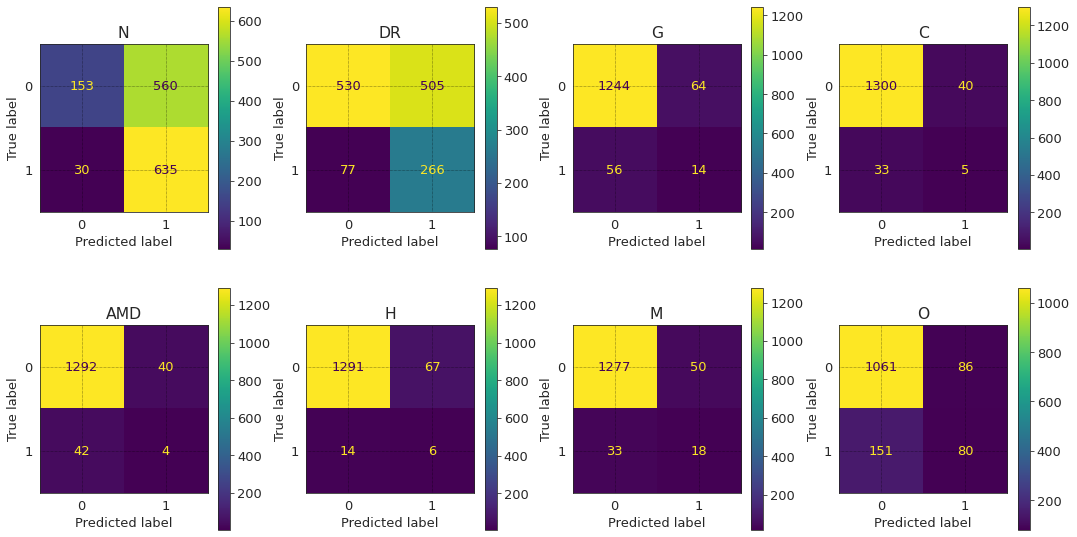

In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/models/SE_resnet34_oversample.h5',
    custom_objects={'SEResidualUnit': SEResidualUnit})

thresholds = get_thresholds(model, val_dataset)
y_true, y_pred = get_predictions(model, thresholds, test_dataset)
create_confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true, y_pred))